In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from PyEMD import EMD, EEMD, CEEMDAN
import warnings
warnings.filterwarnings('ignore')

In [2]:
from __future__ import division

In [3]:
from matplotlib.colors import ListedColormap

In [23]:
cmap = ['magenta', 'rebeccapurple', 'turquoise','darkcyan', 'mediumslateblue','limegreen','dodgerblue']

In [24]:
pal = sns.color_palette(cmap)
sns.set_palette(pal)
box_pal = sns.color_palette(['turquoise','darkcyan'])
light_pal = sns.color_palette(['mediumslateblue','limegreen'])

### <font color = "limegreen"> Let's look at the available well log data and implement data preprocessing. </font>

In [6]:
def plot_boxplots(data):
    fig, axes = plt.subplots(data.shape[1],1)
    fig.set_figheight(13)
    fig.set_figwidth(8)
    for c in range(data.shape[1]):
        axes[c] = sns.boxplot(data = data[data.columns[c]],
                              ax = axes[c],palette = box_pal,orient='h'
                              ,fliersize=10).set_title(data[data.columns[c]].name)
    plt.tight_layout()

In [20]:
data = pd.read_csv('facies_data.csv')
data.head(10)

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915
5,3,A1 SH,SHRIMPLIN,2795.5,73.97,0.636,14.0,13.385,3.6,1,0.894
6,3,A1 SH,SHRIMPLIN,2796.0,73.72,0.630,15.6,13.930,3.7,1,0.872
7,3,A1 SH,SHRIMPLIN,2796.5,75.65,0.625,16.5,13.920,3.5,1,0.830
8,3,A1 SH,SHRIMPLIN,2797.0,73.79,0.624,16.2,13.980,3.4,1,0.809
9,3,A1 SH,SHRIMPLIN,2797.5,76.89,0.615,16.9,14.220,3.5,1,0.787


In [21]:
# see what there are not some photoelectric effect (PE) values ~ 22% (Problem_1) - the main problem to solve
data.isnull().sum()

Facies         0
Formation      0
Well Name      0
Depth          0
GR             0
ILD_log10      0
DeltaPHI       0
PHIND          0
PE           917
NM_M           0
RELPOS         0
dtype: int64

Shapiro-Wilk test for normality: (0.8756224513053894, 0.0)


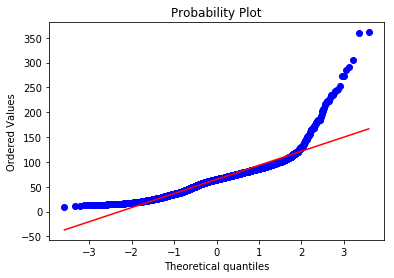

In [9]:
import matplotlib.pyplot as plt
import scipy.stats as stats
#data = np.random.uniform(size=100) 
stats.probplot(data['GR'], dist="norm", plot=plt)
print("Shapiro-Wilk test for normality:", stats.shapiro(data['GR']))
plt.show()

Shapiro-Wilk test for normality: (0.9927169680595398, 1.0333144658935395e-13)


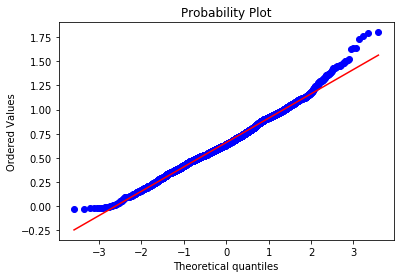

In [10]:
import matplotlib.pyplot as plt
import scipy.stats as stats
#data = np.random.uniform(size=100) 
stats.probplot(data['ILD_log10'], dist="norm", plot=plt)
print("Shapiro-Wilk test for normality:", stats.shapiro(data['ILD_log10']))
plt.show()

Shapiro-Wilk test for normality: (0.8470496535301208, 0.0)


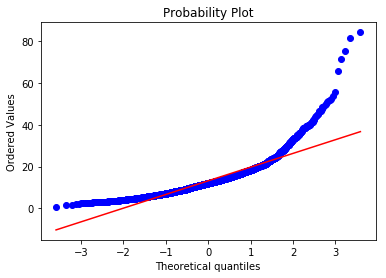

In [11]:
import matplotlib.pyplot as plt
import scipy.stats as stats
#data = np.random.uniform(size=100) 
stats.probplot(data['PHIND'], dist="norm", plot=plt)
print("Shapiro-Wilk test for normality:", stats.shapiro(data['PHIND']))
plt.show()

Shapiro-Wilk test for normality: (0.9567573666572571, 1.9860614395485884e-33)


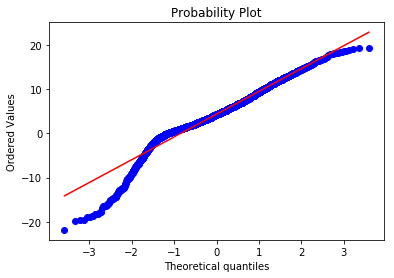

In [12]:
import matplotlib.pyplot as plt
import scipy.stats as stats
#data = np.random.uniform(size=100) 
stats.probplot(data['DeltaPHI'], dist="norm", plot=plt)
print("Shapiro-Wilk test for normality:", stats.shapiro(data['DeltaPHI']))
plt.show()

Shapiro-Wilk test for normality: (nan, 1.0)


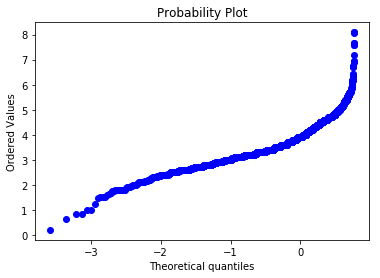

In [13]:
import matplotlib.pyplot as plt
import scipy.stats as stats
#data = np.random.uniform(size=100) 
stats.probplot(data['PE'], dist="norm", plot=plt)
print("Shapiro-Wilk test for normality:", stats.shapiro(data['PE']))
plt.show()

<font color = "blue"> Significantly, an important characteristic for any data of geophysical studies is the absolute difference of various physical indicators (Fig.1). For example, in the given well log data set, gamma radiation is measured in API; resistivity – in ohm-meters; the photoelectric effect is measured in electron volts. In the light of the above, the comparison of geophysical quantities is incorrect without normalization (or standartization) – it eliminates the difference in the values of these quantities. (Problem_2) </font>

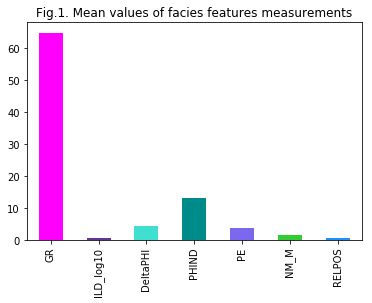

In [25]:
features = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND','PE','NM_M', 'RELPOS']
feature_vectors = data[features]
feature_vectors.mean().plot(kind='bar',title='Fig.1. Mean values of facies features measurements', colors = cmap)

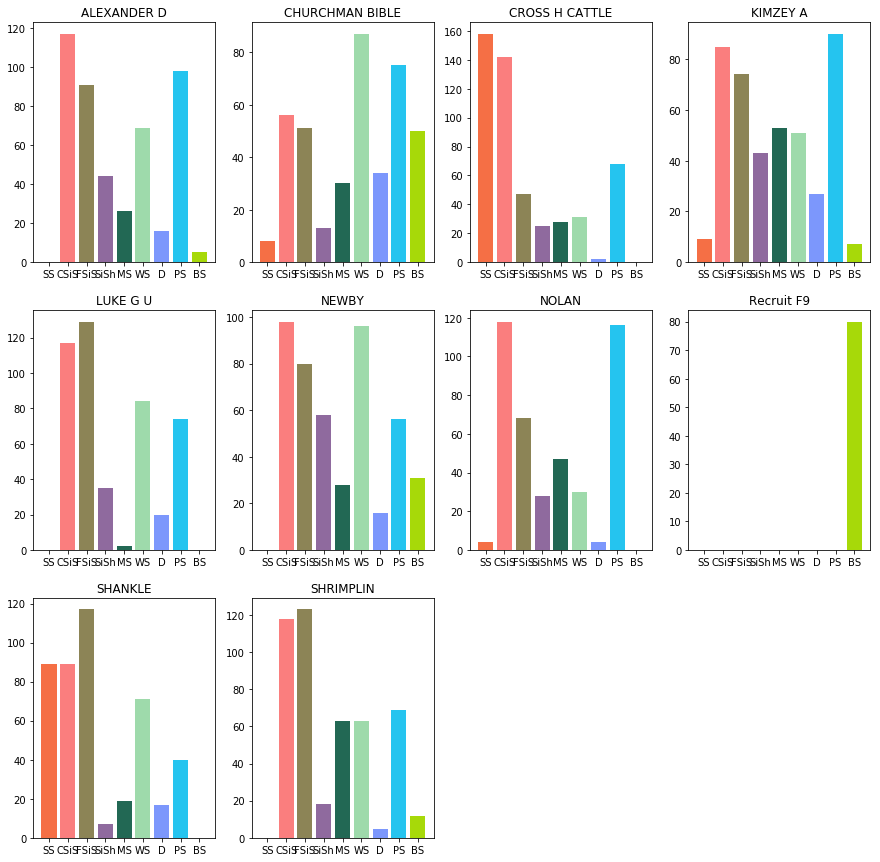

In [26]:
# Let's look at the distribution of facies in different wells
facies_names = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D', 'PS', 'BS']
facies_colors = ['#F56F45', '#FA7E7E','#8C8456','#8F6A9E',
       '#226854','#9EDAAB', '#7C97FC', '#25C4EF', '#A7D909'] 
well = data['Well Name'].values
depth = data['Depth'].values
facies_numb = data['Facies'].values

plt.figure(figsize=(15,15))

for i, wn in enumerate(np.unique(well)):
    ax = plt.subplot(3, 4, i+1)
    hist = np.histogram(facies_numb[well == wn], bins=np.arange(10)+.7)
    plt.bar(np.arange(len(hist[0])), hist[0], color=facies_colors, align='center')
    ax.set_title(wn)
    ax.set_xticks(np.arange(len(hist[0])))
    ax.set_xticklabels(facies_names)
# Скважина Recruit F9 - псевдо-скважина, введенная специально для улучшения качества классиификации фации BS
# Скважина KIMZEY A содержит все имеющиеся классы (типы фаций), поэтому в дальнейшем при  классификации 
# эта скважина будет сипользоваться в качестве тестовой

In [27]:
wells = data['Well Name'].unique()
wells

array(['SHRIMPLIN', 'ALEXANDER D', 'SHANKLE', 'LUKE G U', 'KIMZEY A',
       'CROSS H CATTLE', 'NOLAN', 'Recruit F9', 'NEWBY',
       'CHURCHMAN BIBLE'], dtype=object)

In [17]:
data = data.drop(['Formation','RELPOS'],axis = 1)
data = data.sort_values('PE')
data = data.reset_index()
data.NM_M.replace(2,0,inplace=True)
data = data.drop(['index'],axis = 1)

In [18]:
real = ['GR','ILD_log10','DeltaPHI','PHIND']

In [19]:
real_data = data.drop(['Facies','Well Name','NM_M'],axis=1).fillna(data.mean())

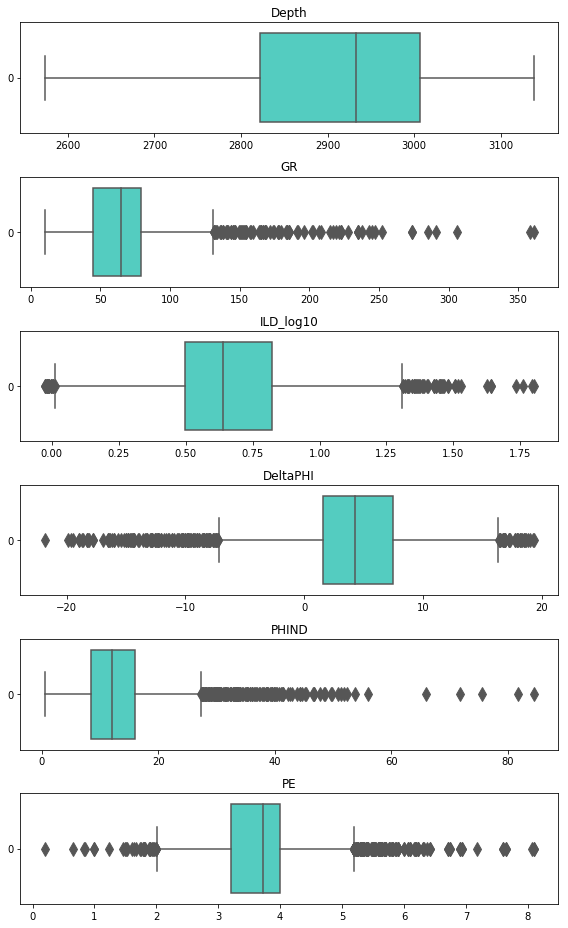

In [20]:
plot_boxplots(real_data)

### <font color = "limegreen"> EMD. </font>

In [21]:
Facies = data.Facies
Facies = pd.get_dummies(Facies)
PE = data.PE.dropna()
Depth = data.Depth
NM_M = data.NM_M
names = data['Well Name']
names.to_csv('names_col_sorted.csv')
names = pd.get_dummies(names)
#data = data.drop(['Facies','PE','Depth','NM_M','Well Name'],axis=1)
data = data.drop(['Facies','PE','NM_M'],axis=1)

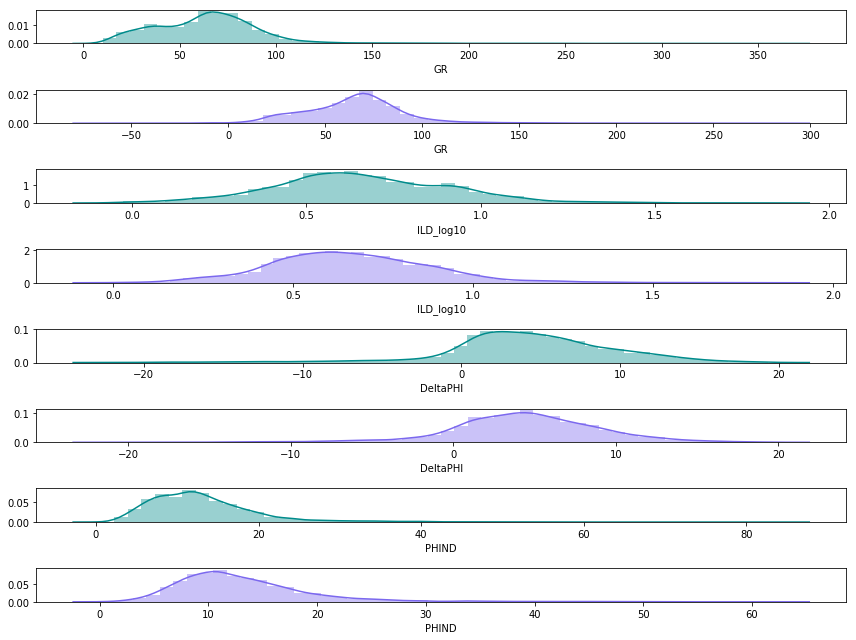

In [30]:
data_emd = pd.DataFrame(data)
plt.figure(figsize=(12,9))
plt.subplot(8,1,1)
sns.distplot(data_emd['GR'],color='darkcyan')
data_emd['GR'] = data_emd['GR']-EMD().emd(np.array(data_emd['GR']))[0]
plt.subplot(8,1,2)
sns.distplot(data_emd['GR'],color='mediumslateblue')
plt.subplot(8,1,3)
sns.distplot(data_emd['ILD_log10'],color='darkcyan')
data_emd['ILD_log10'] = data_emd['ILD_log10']-EMD().emd(np.array(data_emd['ILD_log10']))[0]
plt.subplot(8,1,4)
sns.distplot(data_emd['ILD_log10'],color='mediumslateblue')
plt.subplot(8,1,5)
sns.distplot(data_emd['DeltaPHI'],color='darkcyan')
data_emd['DeltaPHI'] = data_emd['DeltaPHI']-EMD().emd(np.array(data_emd['DeltaPHI']))[0]
plt.subplot(8,1,6)
sns.distplot(data_emd['DeltaPHI'],color='mediumslateblue')
plt.subplot(8,1,7)
sns.distplot(data_emd['PHIND'],color='darkcyan')
data_emd['PHIND'] = data_emd['PHIND']-EMD().emd(np.array(data_emd['PHIND']))[0]
plt.subplot(8,1,8)
sns.distplot(data_emd['PHIND'],color='mediumslateblue')
plt.tight_layout()
plt.show()

In [101]:
#data_emd.to_csv('data_emd_.csv',index = False)
data_emd = pd.read_csv('data_emd_.csv', encoding  = 'utf-8')
data_emd.head(10)

,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND
0,LUKE G U,2808.5,88.502397,0.575402,-4.939346,48.852072
1,CROSS H CATTLE,2788.0,88.051280,0.509701,-7.211033,57.805925
2,CROSS H CATTLE,2633.0,107.541489,0.537641,-6.643876,62.226960
3,CROSS H CATTLE,2633.5,122.416066,0.597912,-6.610304,59.450354
4,CROSS H CATTLE,2632.5,110.299264,0.576369,-8.244920,51.439194
5,LUKE G U,2808.0,89.543521,0.529882,-7.177263,45.880875
6,CROSS H CATTLE,2634.0,83.221072,0.537477,-2.673813,48.244631
7,CHURCHMAN BIBLE,3003.5,84.219034,0.580757,-5.118990,51.739156
8,SHANKLE,2858.0,79.996685,0.617481,-11.665840,52.072762
9,CHURCHMAN BIBLE,3004.0,64.848622,0.625056,-12.559401,47.958161


Text(0, 0.5, 'GR (API)')

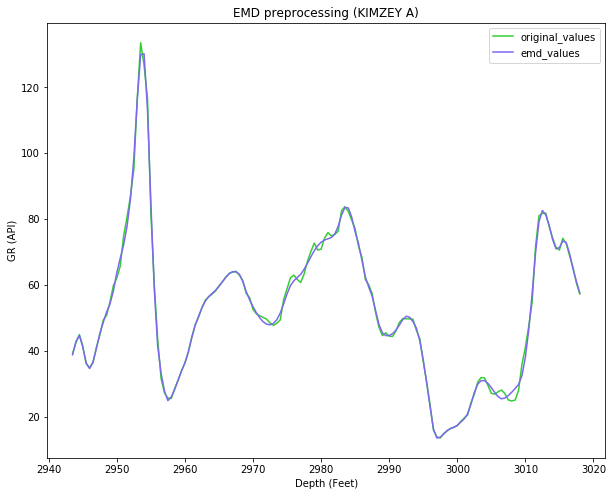

In [102]:
# KIMZEY A
data1 = data[[features[0],'Depth']][data['Well Name'] == wells[4]]
data1 = data1[50:200]
data2 = data_emd[[features[0],'Depth']][data_emd['Well Name'] == wells[4]]
data2 = data2.sort_values(by=['Depth'])
data2.reset_index(inplace = True)
data2 = data2.drop('index',axis=1)
data2 = data2[50:200]
plt.figure(figsize=(10,8))
plt.plot(data1['Depth'],data1['GR'], color = 'limegreen', label = 'original_values')
plt.plot(data2['Depth'],data2['GR'], color ='mediumslateblue', label='emd_values')
plt.legend()

plt.title("EMD preprocessing (KIMZEY A)")
plt.xlabel('Depth (Feet)')
#plt.xticks(range(50,200),xx, rotation =90)
plt.ylabel('GR (API)')

Text(0, 0.5, 'ILD_log10 (Ohms)')

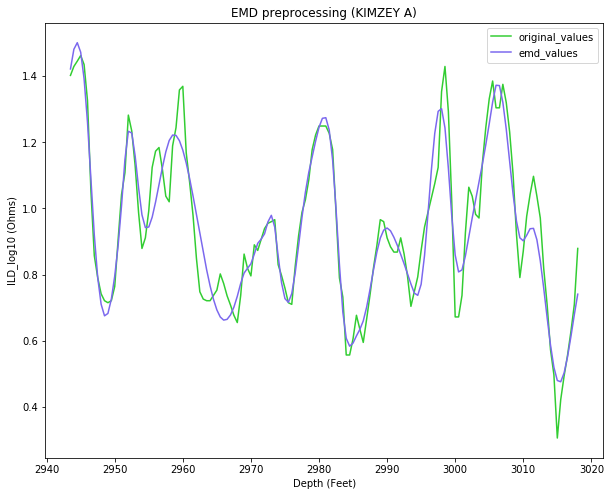

In [103]:
# KIMZEY A
data1 = data[[features[1],'Depth']][data['Well Name'] == wells[4]]
data1 = data1[50:200]
data2 = data_emd[[features[1],'Depth']][data_emd['Well Name'] == wells[4]]
data2 = data2.sort_values(by=['Depth'])
data2.reset_index(inplace = True)
data2 = data2.drop('index',axis=1)
data2 = data2[50:200]
plt.figure(figsize=(10,8))
plt.plot(data1['Depth'],data1['ILD_log10'], color = 'limegreen', label = 'original_values')
plt.plot(data2['Depth'],data2['ILD_log10'], color ='mediumslateblue', label='emd_values')
plt.legend()

plt.title("EMD preprocessing (KIMZEY A)")
plt.xlabel('Depth (Feet)')
plt.ylabel('ILD_log10 (Ohms)')

In [119]:
facies_data = pd.read_csv('facies_data.csv',encoding = 'utf-8')
EMD_data = pd.DataFrame(facies_data)
params = ['GR','ILD_log10',  'DeltaPHI','PHIND', 'PE']
emd = EMD()

for i in wells:
    for j in params:
        IMFs = emd(np.array(EMD_data[j][EMD_data['Well Name'] == i]))
        EMD_data[j][EMD_data['Well Name'] == i] -= IMFs[0]

EMD_data.isnull().any().any()

EMD_data.to_csv('EMD_data01.csv', index = False)

#IMFs = emd(np.array(EMD_data[params[0]][EMD_data['Well Name'] == wells[0]]))
#plt.figure(figsize=(10,8))

#plt.plot(EMD_data[params[0]][EMD_data['Well Name'] == wells[0]], color = 'limegreen', label = 'original_values')
#plt.plot((EMD_data[params[0]][EMD_data['Well Name'] == wells[0]]-IMFs[0]),color ='mediumslateblue', label='emd_values')
#plt.legend()
#plt.title("EMD preprocessing (SHRIMPLIN)")
#plt.xlabel('Depth (Feet)')
#plt.ylabel('GR (API)')


INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.
INFO:PyEMD.EMD:Max iterations reached for IMF. Continueing with another IMF.


In [122]:
emd = EMD()
IMFs = emd(np.array(data_emd[features[0]][data_emd['Well Name'] == wells[4]]))

7

In [117]:
EMD_data = pd.read_csv('EMD_data.csv', encoding = 'utf-8')
params = ['GR','ILD_log10',  'DeltaPHI','PHIND', 'PE']

Text(0, 0.5, 'GR (API)')

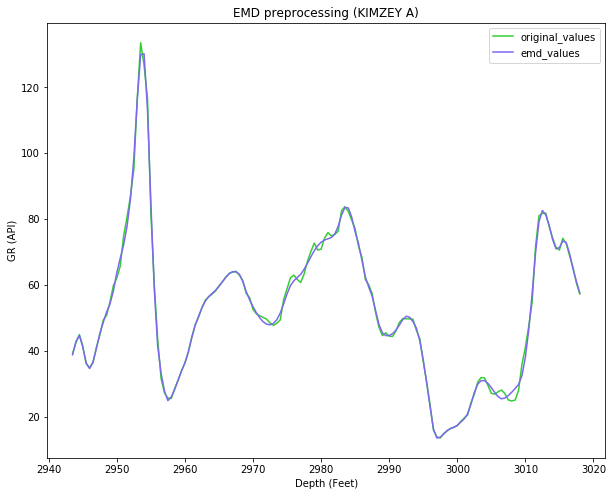

In [148]:
# KIMZEY A 
data1 = data[[features[0],'Depth']][data['Well Name'] == wells[4]]
data1 = data1.sort_values(by=['Depth'])
data1 = data1[50:200]
data2 = data_emd[[features[0],'Depth']][data_emd['Well Name'] == wells[4]]
data2 = data2.sort_values(by=['Depth'])
data2.reset_index(inplace = True)
data2 = data2.drop('index',axis=1)
IMFs_ = IMFs[5]
data2 = data2[50:200]
plt.figure(figsize=(10,8))
#-IMFs_[50:200]
plt.plot(data1['Depth'],data1['GR'], color = 'limegreen', label = 'original_values')
plt.plot(data2['Depth'],data2['GR'], color ='mediumslateblue', label='emd_values')
plt.legend()

plt.title("EMD preprocessing (KIMZEY A)")
plt.xlabel('Depth (Feet)')
plt.ylabel('GR (API)')

In [269]:
data_ceemd = pd.read_csv('data_ceemd.csv',encoding = 'utf-8')
#CEEMD_data = pd.read_csv('CEEMD_data.csv',encoding = 'utf-8')
EEMD_data_23 = pd.read_csv('EEMD_data_21.csv',encoding = 'utf-8')

In [28]:
facies_data = pd.read_csv('facies_data.csv',encoding = 'utf-8')
EMD_data = pd.read_csv('EMD_data.csv',encoding = 'utf-8')
EEMD_data = pd.read_csv('EEMD_data.csv',encoding = 'utf-8')

print(mean_squared_error(EMD_data[EMD_data['Well Name'] == 'SHANKLE']['GR'],facies_data[facies_data['Well Name'] == 'SHANKLE']['GR']))
print(mean_squared_error(EEMD_data[EEMD_data['Well Name'] == 'SHANKLE']['GR'],facies_data[facies_data['Well Name'] == 'SHANKLE']['GR']))
#print(mean_squared_error(EEMD_data['GR'],facies_data['GR']))
print(mean_squared_error(EMD_data[EMD_data['Well Name'] == 'SHANKLE']['ILD_log10'],facies_data[facies_data['Well Name'] == 'SHANKLE']['ILD_log10']))
print(mean_squared_error(EEMD_data[EEMD_data['Well Name'] == 'SHANKLE']['ILD_log10'],facies_data[facies_data['Well Name'] == 'SHANKLE']['ILD_log10']))
#print(mean_squared_error(CEEMD_data['ILD_log10'],facies_data['ILD_log10']))
print(mean_squared_error(EMD_data[EMD_data['Well Name'] == 'SHANKLE']['DeltaPHI'],facies_data[facies_data['Well Name'] == 'SHANKLE']['DeltaPHI']))
print(mean_squared_error(EEMD_data[EEMD_data['Well Name'] == 'SHANKLE']['DeltaPHI'],facies_data[facies_data['Well Name'] == 'SHANKLE']['DeltaPHI']))
#print(mean_squared_error(CEEMD_data['DeltaPHI'],facies_data['DeltaPHI']))
print(mean_squared_error(EMD_data[EMD_data['Well Name'] == 'SHANKLE']['PHIND'],facies_data[facies_data['Well Name'] == 'SHANKLE']['PHIND']))
print(mean_squared_error(EEMD_data[EEMD_data['Well Name'] == 'SHANKLE']['PHIND'],facies_data[facies_data['Well Name'] == 'SHANKLE']['PHIND']))
#print(mean_squared_error(CEEMD_data['PHIND'],facies_data['PHIND']))

print(mean_squared_error(EMD_data[EMD_data['Well Name'] == 'SHANKLE']['PE'],facies_data[facies_data['Well Name'] == 'SHANKLE']['PE']))
print(mean_squared_error(EEMD_data[EEMD_data['Well Name'] == 'SHANKLE']['PE'],facies_data[facies_data['Well Name'] == 'SHANKLE']['PE']))
#print(mean_squared_error(CEEMD_data['PE'],facies_data['PE']))

45.51221100507917
60.904468580709015
0.002859500801084279
0.0031327361523297336
8.761244330220299
10.143146436594499
22.328037553519682
23.69958514389975
0.07443885941745337
0.08544666579946336


In [14]:
EMD_data = pd.read_csv('EMD_data01.csv', encoding = 'utf-8')
EEMD_data = pd.read_csv('EEMD_data01.csv', encoding = 'utf-8')
facies_data = pd.read_csv('facies_data.csv',encoding = 'utf-8')
print(mean_squared_error(EMD_data[EMD_data['Well Name'] == 'SHANKLE']['GR'],facies_data[facies_data['Well Name'] == 'SHANKLE']['GR']))
print(mean_squared_error(EEMD_data[EEMD_data['Well Name'] == 'SHANKLE']['GR'],facies_data[facies_data['Well Name'] == 'SHANKLE']['GR']))
#print(mean_squared_error(EEMD_data['GR'],facies_data['GR']))
print(mean_squared_error(EMD_data[EMD_data['Well Name'] == 'SHANKLE']['ILD_log10'],facies_data[facies_data['Well Name'] == 'SHANKLE']['ILD_log10']))
print(mean_squared_error(EEMD_data[EEMD_data['Well Name'] == 'SHANKLE']['ILD_log10'],facies_data[facies_data['Well Name'] == 'SHANKLE']['ILD_log10']))
#print(mean_squared_error(CEEMD_data['ILD_log10'],facies_data['ILD_log10']))
print(mean_squared_error(EMD_data[EMD_data['Well Name'] == 'SHANKLE']['DeltaPHI'],facies_data[facies_data['Well Name'] == 'SHANKLE']['DeltaPHI']))
print(mean_squared_error(EEMD_data[EEMD_data['Well Name'] == 'SHANKLE']['DeltaPHI'],facies_data[facies_data['Well Name'] == 'SHANKLE']['DeltaPHI']))
#print(mean_squared_error(CEEMD_data['DeltaPHI'],facies_data['DeltaPHI']))
print(mean_squared_error(EMD_data[EMD_data['Well Name'] == 'SHANKLE']['PHIND'],facies_data[facies_data['Well Name'] == 'SHANKLE']['PHIND']))
print(mean_squared_error(EEMD_data[EEMD_data['Well Name'] == 'SHANKLE']['PHIND'],facies_data[facies_data['Well Name'] == 'SHANKLE']['PHIND']))
#print(mean_squared_error(CEEMD_data['PHIND'],facies_data['PHIND']))

print(mean_squared_error(EMD_data[EMD_data['Well Name'] == 'SHANKLE']['PE'],facies_data[facies_data['Well Name'] == 'SHANKLE']['PE']))
print(mean_squared_error(EEMD_data[EEMD_data['Well Name'] == 'SHANKLE']['PE'],facies_data[facies_data['Well Name'] == 'SHANKLE']['PE']))

45.51221100507917
22.007426410180702
0.002859500801084279
0.00032088245665038795
8.761244330220299
3.506920747783075
22.328037553519682
5.086303162642733
0.07443885941745337
0.02259103770832142


In [29]:
facies_data = pd.read_csv('facies_data.csv',encoding = 'utf-8')
print(mean_squared_error(data_emd['GR'],data['GR']))
print(mean_squared_error(data_eemd['GR'],data['GR']))
print(mean_squared_error(data_ceemd['GR'],data['GR']))

NameError: name 'data_emd' is not defined

In [237]:
print(mean_squared_error(data_emd['ILD_log10'],data['ILD_log10']))
print(mean_squared_error(data_eemd['ILD_log10'],data['ILD_log10']))
print(mean_squared_error(data_ceemd['ILD_log10'],data['ILD_log10']))

0.016195445490798214
0.013611382660347058
0.020042769040127854


In [ ]:
# Define signal
t = np.linspace(0, 1, 200)
s = np.cos(11*2*np.pi*t*t) + 6*t*t

# Execute EMD on signal
IMF = EMD().emd(s,t)
N = IMF.shape[0]+1

# Plot results
plt.subplot(N,1,1)
plt.plot(t, s, 'r')
plt.title("Input signal: $S(t)=cos(22\pi t^2) + 6t^2$")
plt.xlabel("Time [s]")

for n, imf in enumerate(IMF):
    plt.subplot(N,1,n+2)
    plt.plot(t, imf, 'g')
    plt.title("IMF "+str(n+1))
    plt.xlabel("Time [s]")

plt.tight_layout()
plt.savefig('simple_example')
plt.show()

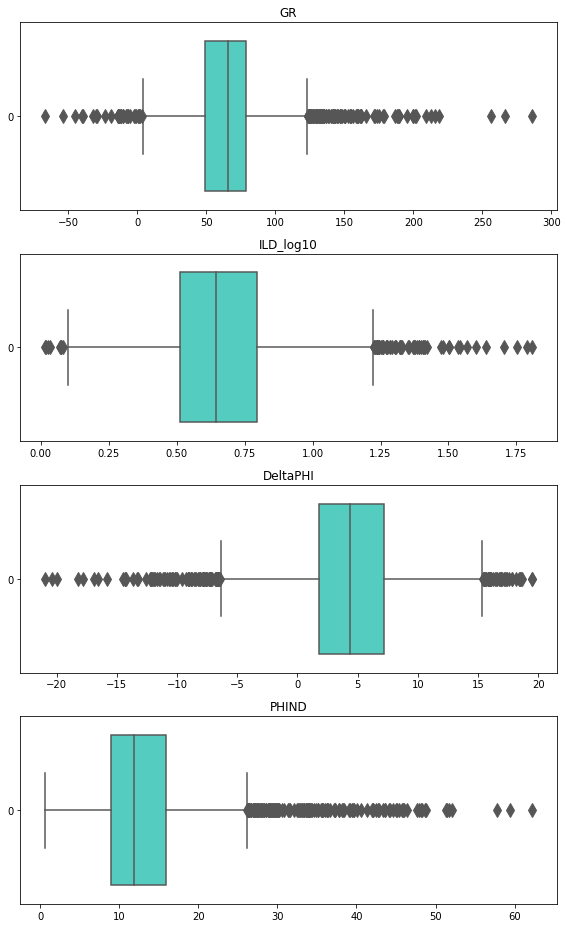

In [104]:
plot_boxplots(data_emd[real])

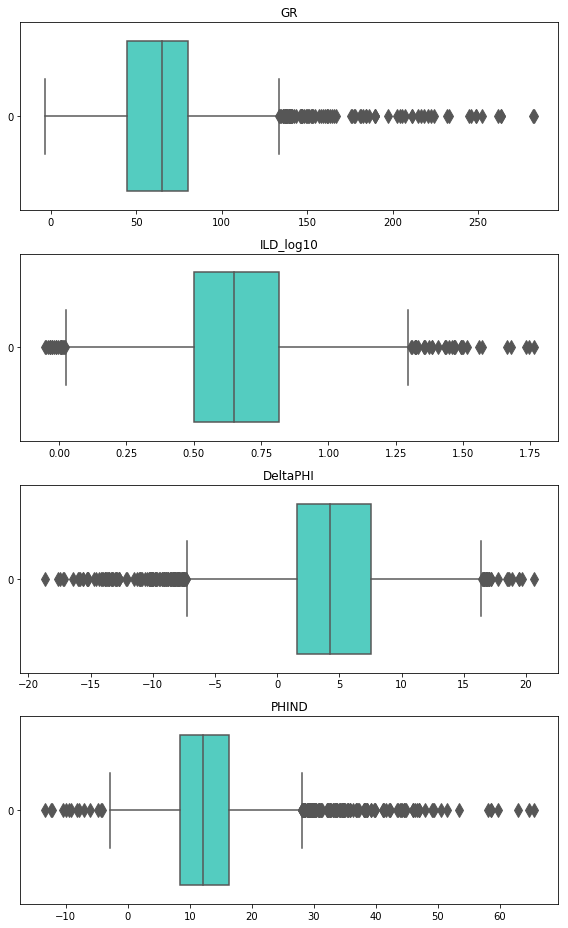

In [184]:
EMD_data = pd.read_csv('EMD_data.csv', encoding = 'utf-8')
#EMD_data_ = EMD_data[EMD_data['Well Name'] in ['SHANKLE','SHRIMPLIN']]
plot_boxplots(EMD_data[real])

### <font color = "limegreen"> EEMD. </font>

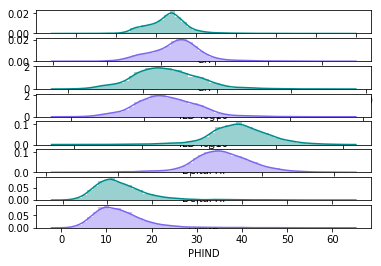

In [15]:
data_eemd = pd.DataFrame(data)
plt.subplot(8,1,1)
sns.distplot(data_eemd['GR'],color='darkcyan')
data_eemd['GR'] = data_eemd['GR']-EEMD(max_imf=5).eemd(np.array(data_eemd['GR']))[0]
plt.subplot(8,1,2)
sns.distplot(data_eemd['GR'],color='mediumslateblue')
plt.subplot(8,1,3)
sns.distplot(data_eemd['ILD_log10'],color='darkcyan')
data_eemd['ILD_log10'] = data_eemd['ILD_log10']-EEMD(max_imf=5).eemd(np.array(data_eemd['ILD_log10']))[0]
plt.subplot(8,1,4)
sns.distplot(data_eemd['ILD_log10'],color='mediumslateblue')
plt.subplot(8,1,5)
sns.distplot(data_eemd['DeltaPHI'],color='darkcyan')
data_eemd['DeltaPHI'] = data_eemd['DeltaPHI']-EEMD(max_imf=5).eemd(np.array(data_eemd['DeltaPHI']))[0]
plt.subplot(8,1,6)
sns.distplot(data_eemd['DeltaPHI'],color='mediumslateblue')
plt.subplot(8,1,7)
sns.distplot(data_eemd['PHIND'],color='darkcyan')
data_eemd['PHIND'] = data_eemd['PHIND']-EEMD(max_imf=5).eemd(np.array(data_eemd['PHIND']))[0]
plt.subplot(8,1,8)
sns.distplot(data_eemd['PHIND'],color='mediumslateblue')
plt.tight_layout()
plt.show()

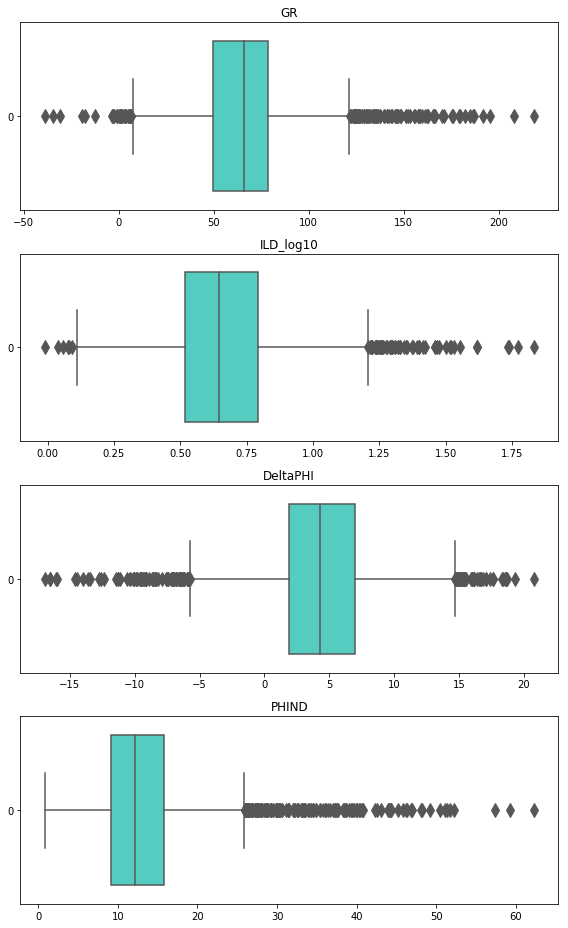

In [16]:
plot_boxplots(data_eemd[real])

In [6]:
facies_data = pd.read_csv('facies_data.csv', encoding = 'utf-8')
EEMD_data = pd.read_csv('EEMD_data.csv', encoding = 'utf-8')

In [10]:
facies_data = pd.read_csv('facies_data.csv',encoding = 'utf-8')
EEMD_data = pd.DataFrame(facies_data)
params = ['GR','ILD_log10',  'DeltaPHI','PHIND', 'PE']
eemd = EEMD()

for i in wells:
    for j in params:
        IMFs = eemd(np.array(EEMD_data[j][EEMD_data['Well Name'] == i]))
        if i == 'ALEXANDER D' or i== 'Recruit F9' or i == 'KIMZEY A':
            if j!=4 and len(IMFs) >=7 :
                 EEMD_data[j][EEMD_data['Well Name'] == i] -= IMFs[0] + IMFs[1] + IMFs[2] + IMFs[3]
            elif j!=4 and len(IMFs) <= 2:
                EEMD_data[j][EEMD_data['Well Name'] == i] -= IMFs[0] 
        elif len(IMFs) >= 7:
            EEMD_data[j][EEMD_data['Well Name'] == i] -= IMFs[0] + IMFs[1] + IMFs[2] + IMFs[3]
        elif len(IMFs) >= 5:
            EEMD_data[j][EEMD_data['Well Name'] == i] -= IMFs[0] + IMFs[1] + IMFs[2] 
        elif len(IMFs) >= 4:
            EEMD_data[j][EEMD_data['Well Name'] == i] -= IMFs[0] + IMFs[1] 
        else :
            EEMD_data[j][EEMD_data['Well Name'] == i] -= IMFs[0] 
        
        #if len(IMFs) > 3 and len(IMFs) > 7:
        #   EEMD_data[j][EEMD_data['Well Name'] == i] -= IMFs[3]
EEMD_data.isnull().any().any()

EEMD_data.to_csv('EEMD_data_28new.csv', index = False)

In [122]:
facies_data = pd.read_csv('facies_data.csv',encoding = 'utf-8')
EEMD_data = pd.DataFrame(facies_data)
params = ['GR','ILD_log10',  'DeltaPHI','PHIND', 'PE']
eemd = EEMD(maximf=5)

for i in wells:
    for j in params:
        IMFs = eemd(np.array(EEMD_data[j][EEMD_data['Well Name'] == i]))
        EEMD_data[j][EEMD_data['Well Name'] == i] -= IMFs[0] 
        
        #if len(IMFs) > 3 and len(IMFs) > 7:
        #   EEMD_data[j][EEMD_data['Well Name'] == i] -= IMFs[3]
EEMD_data.isnull().any().any()

EEMD_data.to_csv('EEMD_data01.csv', index = False)

In [ ]:
EEMD_data

In [18]:
EEMD_data = pd.DataFrame(facies_data)
params = ['GR','ILD_log10',  'DeltaPHI','PHIND', 'PE']
eemd = EEMD()

for i in wells:
    for j in params:
        IMFs = eemd(np.array(EEMD_data[j][EEMD_data['Well Name'] == i]))
        EEMD_data[j][EEMD_data['Well Name'] == i] -= IMFs[0] 
EEMD_data.isnull().any().any()

EEMD_data.to_csv('EEMD_data_28.csv', index = False)

In [19]:
EEMD_data.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,82.163534,0.667474,11.595958,12.780976,4.375883,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,76.940570,0.653118,13.218601,12.568886,4.014404,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,75.076336,0.642091,14.138738,12.677597,3.634599,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,91.085714,0.683748,14.825167,14.019940,3.576107,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,77.433454,0.625177,13.602515,12.523622,3.425517,1,0.915


Text(0, 0.5, 'GR (API)')

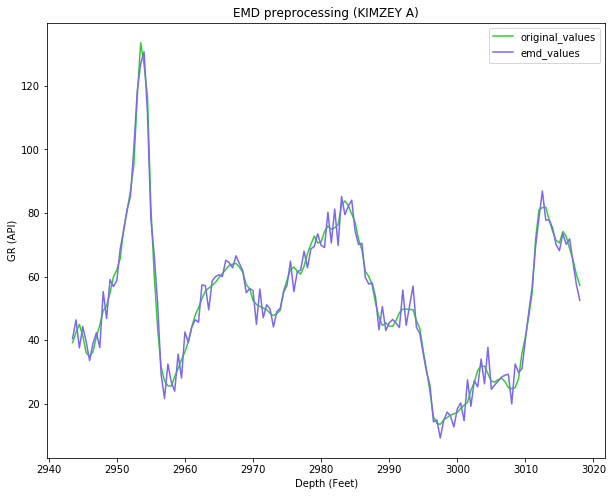

In [28]:
# KIMZEY A
facies_data = pd.read_csv('facies_data.csv',encoding = 'utf-8')
data1 = facies_data[[features[0],'Depth']][EEMD_data['Well Name'] == wells[4]]
#data1 = data1.sort_values(by=['Depth'])
data1 = data1[50:200]
data2 = EEMD_data[[features[0],'Depth']][EEMD_data['Well Name'] == wells[4]]
data2 = data2.sort_values(by=['Depth'])
#data2.reset_index(inplace = True)
#data2 = data2.drop('index',axis=1)
data2 = data2[50:200]
plt.figure(figsize=(10,8))
plt.plot(data1['Depth'],data1['GR'], color = 'limegreen', label = 'original_values')
plt.plot(data2['Depth'],data2['GR'], color ='mediumslateblue', label='emd_values')
plt.legend()

plt.title("EMD preprocessing (KIMZEY A)")
plt.xlabel('Depth (Feet)')
plt.ylabel('GR (API)')

In [155]:
EEMD_data = pd.read_csv('EEMD_data.csv', encoding = 'utf-8')
eemd = EEMD(max_imf=5)
IMFs2 = eemd(np.array(EEMD_data[features[0]][EEMD_data['Well Name'] == wells[4]]))

Text(0, 0.5, 'GR (API)')

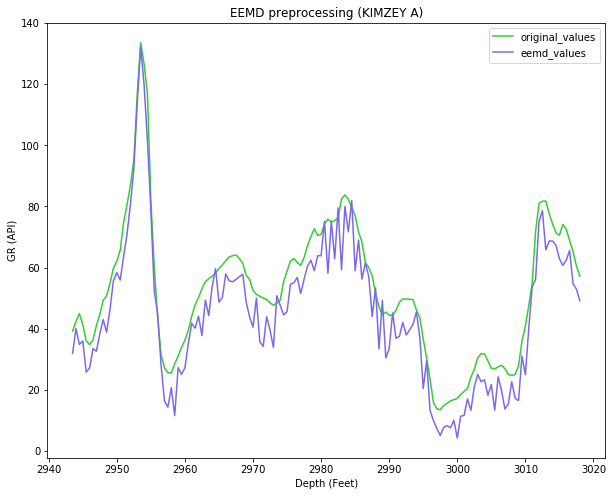

In [153]:
# KIMZEY A 
data1 = data[[features[0],'Depth']][data['Well Name'] == wells[4]]
data1 = data1.sort_values(by=['Depth'])
data1 = data1[50:200]
data2 = data_eemd[[features[0],'Depth']][data_eemd['Well Name'] == wells[4]]
data2 = data2.sort_values(by=['Depth'])
data2.reset_index(inplace = True)
data2 = data2.drop('index',axis=1)
IMFs_ = IMFs2[9]
data2 = data2[50:200]
plt.figure(figsize=(10,8))
#-IMFs_[50:200]
plt.plot(data1['Depth'],data1['GR'], color = 'limegreen', label = 'original_values')
plt.plot(data2['Depth'],data2['GR']-IMFs_[50:200], color ='mediumslateblue', label='eemd_values')
plt.legend()

plt.title("EEMD preprocessing (KIMZEY A)")
plt.xlabel('Depth (Feet)')
plt.ylabel('GR (API)')

### <font color = "limegreen"> CEEMD. </font>

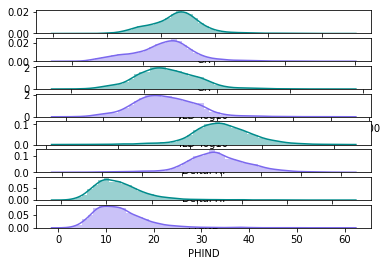

In [17]:
data_ceemd = pd.DataFrame(data)
plt.subplot(8,1,1)
sns.distplot(data_ceemd['GR'],color='darkcyan')
data_ceemd['GR'] = data_eemd['GR']-CEEMDAN().ceemdan(np.array(data_ceemd['GR']))[0]
plt.subplot(8,1,2)
sns.distplot(data_ceemd['GR'],color='mediumslateblue')
plt.subplot(8,1,3)
sns.distplot(data_ceemd['ILD_log10'],color='darkcyan')
data_ceemd['ILD_log10'] = data_eemd['ILD_log10']-CEEMDAN().ceemdan(np.array(data_ceemd['ILD_log10']))[0]
plt.subplot(8,1,4)
sns.distplot(data_ceemd['ILD_log10'],color='mediumslateblue')
plt.subplot(8,1,5)
sns.distplot(data_ceemd['DeltaPHI'],color='darkcyan')
data_ceemd['DeltaPHI'] = data_eemd['DeltaPHI']-CEEMDAN().ceemdan(np.array(data_ceemd['DeltaPHI']))[0]
plt.subplot(8,1,6)
sns.distplot(data_ceemd['DeltaPHI'],color='mediumslateblue')
plt.subplot(8,1,7)
sns.distplot(data_ceemd['PHIND'],color='darkcyan')
data_ceemd['PHIND'] = data_eemd['PHIND']-CEEMDAN().ceemdan(np.array(data_ceemd['PHIND']))[0]
plt.subplot(8,1,8)
sns.distplot(data_ceemd['PHIND'],color='mediumslateblue')
plt.tight_layout()
plt.show()

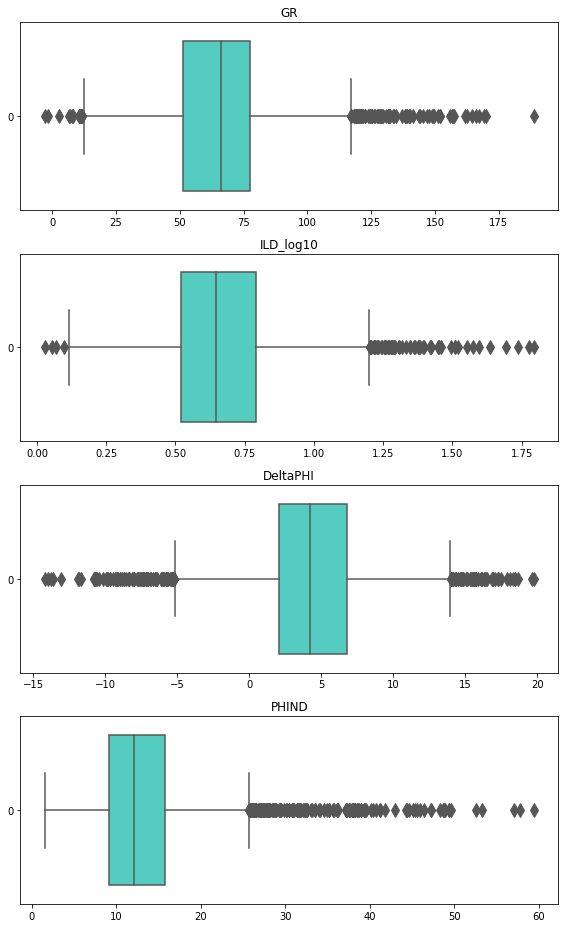

In [18]:
plot_boxplots(data_ceemd[real])

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, RobustScaler, PowerTransformer

In [24]:
EMD_data.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,79.115909,0.667654,11.280437,12.022698,4.281255,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,81.437869,0.661972,12.849491,11.678287,4.095110,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,82.798595,0.656692,13.910928,11.889727,3.904305,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,82.422239,0.651426,14.372291,12.706277,3.738741,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,78.052803,0.645836,14.525531,13.755231,3.610612,1,0.915


In [81]:
def combine_dataframe_(df,norm):
    #df['Depth'] = Depth
    temp_df = df[['GR','ILD_log10','DeltaPHI','PHIND']]
    temp_df = pd.DataFrame(norm.fit_transform(temp_df))
    temp_df['NM'] = NM_M
    for col in Facies.columns:
        col_name = 'Faci'+str(col)
        temp_df[col_name] = Facies[col]
    return temp_df

In [82]:
def combine_dataframe(df,norm):
    df['Depth'] = Depth
    temp_df = pd.DataFrame(norm.fit_transform(df))
    temp_df.NM = NM_M
    for col in Facies.columns:
        col_name = 'Faci'+str(col)
        temp_df[col_name] = Facies[col]
    return temp_df

In [194]:
#data_emd_ss = combine_dataframe(data_emd,StandardScaler())
EEMD_data.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,83.235088,0.660179,12.746175,10.927719,4.102234,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,87.720633,0.660996,12.851649,11.215019,4.102376,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,84.971991,0.659478,13.426714,12.533152,3.951255,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,76.289305,0.634571,13.518999,12.697033,3.709462,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,76.943691,0.644392,13.973377,13.015749,3.589820,1,0.915


In [95]:
EMD_data = pd.read_csv('EMD_data.csv',encoding = 'utf-8')
EMD_data = EMD_data.drop(['Formation','RELPOS'],axis = 1)
EMD_data = EMD_data.sort_values('PE')
EMD_data = EMD_data.reset_index()
EMD_data.NM_M.replace(2,0,inplace=True)
EMD_data = EMD_data.drop(['index'],axis = 1)
#data = data.drop(['Facies','PE','Depth','NM_M','Well Name'],axis=1)
#EMD_data_pt = combine_dataframe_(EMD_data,PowerTransformer(method='yeo-johnson',standardize=True))
Facies = EMD_data.Facies
Facies = pd.get_dummies(Facies)
PE = EMD_data.PE.dropna()
Depth = EMD_data.Depth
NM_M = EMD_data.NM_M
EMD_data = EMD_data.drop(['Depth'],axis = 1)
#EMD_data

In [75]:
data_emd_ss = combine_dataframe_(EMD_data,StandardScaler())
data_emd_mm = combine_dataframe_(EMD_data,MinMaxScaler())
data_emd_qt = combine_dataframe_(EMD_data,QuantileTransformer())

data_emd_rs = combine_dataframe_(EMD_data,RobustScaler())

data_emd_pt = combine_dataframe_(EMD_data,PowerTransformer(method='yeo-johnson',standardize=True))

In [47]:
data_emd_ss = combine_dataframe(EMD_data,StandardScaler())
data_emd_mm = combine_dataframe(EMD_data,MinMaxScaler())
data_emd_qt = combine_dataframe(EMD_data,QuantileTransformer())

data_emd_rs = combine_dataframe(EMD_data,RobustScaler())

data_emd_pt = combine_dataframe(EMD_data,PowerTransformer(method='yeo-johnson',standardize=True))


ValueError: could not convert string to float: 'A1 SH'

In [136]:
data_emd_ss.to_csv('data_emd_ss21.csv')
data_emd_mm.to_csv('data_emd_mm21.csv')
data_emd_qt.to_csv('data_emd_qt21.csv')
data_emd_rs.to_csv('data_emd_rs21.csv')
data_emd_pt.to_csv('data_emd_pt21.csv')

In [144]:
EEMD_data = pd.read_csv('EEMD_data01.csv',encoding = 'utf-8')
#EEMD_data = EEMD_data.drop(['Formation','RELPOS'],axis = 1)
EEMD_data = EEMD_data.sort_values('PE')
EEMD_data = EEMD_data.reset_index()
EEMD_data.NM_M.replace(2,0,inplace=True)
EEMD_data = EEMD_data.drop(['index'],axis = 1)
Facies = EEMD_data.Facies
Facies = pd.get_dummies(Facies)
PE = EEMD_data.PE.dropna()
Depth = EEMD_data.Depth
NM_M = EEMD_data.NM_M
EEMD_data = EEMD_data.drop(['Depth'],axis = 1)

In [142]:
EEMD_data = pd.read_csv('EEMD_data01.csv',encoding = 'utf-8')
EEMD_data = EEMD_data.sort_values('PE')
EEMD_data[-985:]['Well Name'].unique()
EEMD_data[EEMD_data['Well Name'] == 'KIMZEY A'].shape # 439
EMD_data[EMD_data['Well Name'] == 'KIMZEY A'].shape # 439
EEMD_data[EEMD_data['Well Name'] == 'Recruit F9'].shape # 80
EMD_data[EMD_data['Well Name'] == 'Recruit F9'].shape # 80
EEMD_data[EEMD_data['Well Name'] == 'ALEXANDER D'].shape # 466
EMD_data[EMD_data['Well Name'] == 'ALEXANDER D'].shape # 466

(466, 11)

In [145]:
data_eemd_ss = combine_dataframe_(EEMD_data,StandardScaler())
data_eemd_mm = combine_dataframe_(EEMD_data,MinMaxScaler())
data_eemd_qt = combine_dataframe_(EEMD_data,QuantileTransformer())
data_eemd_rs = combine_dataframe_(EEMD_data,RobustScaler())
data_eemd_pt = combine_dataframe_(EEMD_data,PowerTransformer(method='yeo-johnson',standardize=True))

In [60]:
data_eemd_ss.to_csv('data_emd_ss23.csv')
data_eemd_mm.to_csv('data_emd_mm23.csv')
data_eemd_qt.to_csv('data_emd_qt23.csv')
data_eemd_rs.to_csv('data_emd_rs23.csv')
data_eemd_pt.to_csv('data_emd_pt23.csv')

In [296]:
data_eemd_ss = combine_dataframe(data_eemd,StandardScaler())
data_eemd_mm = combine_dataframe(data_eemd,MinMaxScaler())
data_eemd_qt = combine_dataframe(data_eemd,QuantileTransformer())
data_eemd_rs = combine_dataframe(data_eemd,RobustScaler())
data_eemd_pt = combine_dataframe(data_eemd,PowerTransformer(method='yeo-johnson',standardize=True))

ValueError: could not convert string to float: 'LUKE G U'

In [ ]:
data_eemd_ss.to_csv('data_eemd_ss.csv')
data_eemd_mm.to_csv('data_eemd_mm.csv')
data_eemd_qt.to_csv('data_eemd_qt.csv')
data_eemd_rs.to_csv('data_eemd_rs.csv')
data_eemd_pt.to_csv('data_eemd_pt.csv')

In [ ]:
data_ceemd_ss = combine_dataframe(data_ceemd,StandardScaler())
data_ceemd_mm = combine_dataframe(data_ceemd,MinMaxScaler())
data_ceemd_qt = combine_dataframe(data_ceemd,QuantileTransformer())
data_ceemd_rs = combine_dataframe(data_ceemd,RobustScaler())
data_ceemd_pt = combine_dataframe(data_ceemd,PowerTransformer(method='yeo-johnson',standardize=True))

In [ ]:
data_ceemd_ss.to_csv('data_ceemd_ss.csv')
data_ceemd_mm.to_csv('data_ceemd_mm.csv')
data_ceemd_qt.to_csv('data_ceemd_qt.csv')
data_ceemd_rs.to_csv('data_ceemd_rs.csv')
data_ceemd_pt.to_csv('data_ceemd_pt.csv')

In [12]:
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier,AdaBoostClassifier,AdaBoostRegressor
from sklearn.model_selection import GridSearchCV,cross_val_score, train_test_split
from xgboost.sklearn import XGBRegressor, XGBClassifier
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression,Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

In [150]:
models = [RandomForestRegressor(),XGBRegressor(),AdaBoostRegressor(),KNeighborsRegressor(),Lasso(),Ridge()]
names = ['RF','XGB','Ada','KNeighbors','L1 regularized linear','L2 regularized linear']
params = [{'n_estimators':[10,20,30,50,80,100,150,200,300],
           'max_depth':[2,3,4,5,6],
          'max_features':['auto','sqrt']},
          {'n_estimators':[10,20,30,100,150,200,300],
           'max_depth':[2,3,4,5,6,7],
           'learning_rate':np.arange(0.1,1.0,0.1)},
         {'n_estimators':[10,20,30,50,80,100,150,200,300],
          'learning_rate':np.arange(0.1,2.0,0.1)},
         {'n_neighbors':np.arange(2,20,1),
         'weights':['uniform','distance'],
         'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']},
         {'alpha':np.arange(0.1,1.0,0.05)}, {'alpha':np.arange(0.1,1.0,0.05)}]

In [151]:
def print_regression_stats(name,model):
    print(name+'\n')
    print('Params are:'+str(model.best_params_))
    print('MSE'+str(model.best_score_))

def print_r2_scores(models,x,y_true,model_names):
    for i,model in enumerate(models):
        print ("For model {} MSE score is: {}".format(model_names[i],mean_squared_error(y_true,model.predict(x))))
        print ("For model {} MAE score is: {}".format(model_names[i],mean_absolute_error(y_true,model.predict(x))))        
        print ("For model {} R2 score is: {}".format(model_names[i],r2_score(y_true,model.predict(x))))    
        
def fit_best_estimator(data_train,y_test,df_type_name):
    print ('Now its {} noise and preprocessing types'.format(df_type_name))
    saved_models = list()
    y = data_train.PE
    data_train = data_train.drop(['PE'],axis=1)
    X_train, X_test, y_train, y_test = train_test_split(data_train, y, test_size=0.25)
    for i in range(len(models)):
        model = GridSearchCV(models[i],params[i],scoring='neg_mean_squared_error',cv=6)
        model.fit(X_train,y_train)
        saved_models.append(model)
        print_regression_stats(names[i],model)
    print_r2_scores(saved_models,X_test,y_test,names)
    print('\n\n')

In [152]:
def prepare_data(df,norm):
    pe = norm.fit_transform(np.array(PE).reshape(-1,1))
    df_train = df[:-985]
    df_train['PE'] = pe
    df_test = df[-985:]
    return df_train, df_test

In [160]:
data_emd_ss = pd.read_csv('data_emd_ss21.csv',encoding = 'utf-8')
data_emd_mm = pd.read_csv('data_emd_mm21.csv',encoding = 'utf-8')
data_emd_qt = pd.read_csv('data_emd_qt21.csv',encoding = 'utf-8')
data_emd_rs = pd.read_csv('data_emd_rs21.csv',encoding = 'utf-8')
data_emd_pt = pd.read_csv('data_emd_pt21.csv',encoding = 'utf-8')

In [146]:
data_eemd_ss = pd.read_csv('data_emd_ss23.csv',encoding = 'utf-8')
data_eemd_mm = pd.read_csv('data_emd_mm23.csv',encoding = 'utf-8')
data_eemd_qt = pd.read_csv('data_emd_qt23.csv',encoding = 'utf-8')
data_eemd_rs = pd.read_csv('data_emd_rs23.csv',encoding = 'utf-8')
data_eemd_pt = pd.read_csv('data_emd_pt23.csv',encoding = 'utf-8')

In [79]:
emd_ss_train,emd_ss_test = prepare_data(data_emd_ss,StandardScaler())
emd_mm_train,emd_mm_test = prepare_data(data_emd_mm,MinMaxScaler())
emd_qt_train,emd_qt_test = prepare_data(data_emd_qt,QuantileTransformer())
emd_rs_train,emd_rs_test = prepare_data(data_emd_rs,RobustScaler())
emd_pt_train,emd_pt_test = prepare_data(data_emd_pt,PowerTransformer(method='yeo-johnson',standardize=True))

In [70]:
data_emd_ss

,0,1,2,3,4,Faci1,Faci2,Faci3,Faci4,Faci5,Faci6,Faci7,Faci8,Faci9
0,0.387941,0.041699,-1.105431,1.377289,-0.745531,0,0,1,0,0,0,0,0,0
1,0.070431,0.244869,-0.879492,0.970705,-0.741780,0,0,1,0,0,0,0,0,0
2,0.406032,-0.676008,-4.056844,6.362474,-0.933100,0,0,1,0,0,0,0,0,0
3,0.628107,-0.130616,-0.864190,1.584387,-0.749282,0,0,1,0,0,0,0,0,0
4,0.462681,-0.797531,-3.565351,5.635224,-0.936852,0,0,1,0,0,0,0,0,0
5,0.361226,-0.291589,-0.720954,4.743196,1.449029,0,1,0,0,0,0,0,0,0
6,0.478305,-0.509210,-3.969920,6.363503,-0.891835,0,0,1,0,0,0,0,0,0
7,2.750068,-0.424441,-1.432074,4.732119,0.713758,0,0,1,0,0,0,0,0,0
8,1.677927,0.239457,-2.078174,7.211224,-2.051013,0,1,0,0,0,0,0,0,0
9,0.384738,-0.023154,-0.885173,4.232646,0.511183,0,0,1,0,0,0,0,0,0


In [116]:
data_eemd_ss = pd.read_csv('data_eemd_ss.csv',encoding = 'utf-8')
data_eemd_mm = pd.read_csv('data_eemd_mm.csv',encoding = 'utf-8')
data_eemd_qt = pd.read_csv('data_eemd_qt.csv',encoding = 'utf-8')
data_eemd_rs = pd.read_csv('data_eemd_rs.csv',encoding = 'utf-8')
data_eemd_pt = pd.read_csv('data_eemd_pt.csv',encoding = 'utf-8')

In [146]:
eemd_ss_train,eemd_ss_test = prepare_data(data_eemd_ss,StandardScaler())
eemd_mm_train,eemd_mm_test = prepare_data(data_eemd_mm,MinMaxScaler())
eemd_qt_train,eemd_qt_test = prepare_data(data_eemd_qt,QuantileTransformer())
eemd_rs_train,eemd_rs_test = prepare_data(data_eemd_rs,RobustScaler())
eemd_pt_train,eemd_pt_test = prepare_data(data_eemd_pt,PowerTransformer(method='yeo-johnson',standardize=True))

In [36]:
data_ceemd_ss = pd.read_csv('data_ceemd_ss.csv',encoding = 'utf-8')
data_ceemd_mm = pd.read_csv('data_ceemd_mm.csv',encoding = 'utf-8')
data_ceemd_qt = pd.read_csv('data_ceemd_qt.csv',encoding = 'utf-8')
data_ceemd_rs = pd.read_csv('data_ceemd_rs.csv',encoding = 'utf-8')
data_ceemd_pt = pd.read_csv('data_ceemd_pt.csv',encoding = 'utf-8')

In [37]:
ceemd_ss_train,ceemd_ss_test = prepare_data(data_ceemd_ss,StandardScaler())
ceemd_mm_train,ceemd_mm_test = prepare_data(data_ceemd_mm,MinMaxScaler())
ceemd_qt_train,ceemd_qt_test = prepare_data(data_ceemd_qt,QuantileTransformer())
ceemd_rs_train,ceemd_rs_test = prepare_data(data_ceemd_rs,RobustScaler())
ceemd_pt_train,ceemd_pt_test = prepare_data(data_ceemd_pt,PowerTransformer(method='yeo-johnson',standardize=True))

In [46]:
ceemd_ss_train

,Unnamed: 0,0,1,2,3,4,Faci1,Faci2,Faci3,Faci4,Faci5,Faci6,Faci7,Faci8,Faci9,PE
0,0,1.594281,-0.336767,-2.467746,6.286258,-0.738028,0,0,1,0,0,0,0,0,0,-3.934108
1,1,1.408970,-0.465311,-2.367267,6.865277,-0.891835,0,0,1,0,0,0,0,0,0,-3.436348
2,2,1.669023,-0.462186,-2.705713,7.112974,-2.054765,0,1,0,0,0,0,0,0,0,-3.227645
3,3,1.973593,-0.414185,-2.930163,6.923086,-2.051013,0,1,0,0,0,0,0,0,0,-3.206440
4,4,1.899211,-0.456884,-2.885952,6.489434,-2.058516,0,0,1,0,0,0,0,0,0,-3.052425
5,5,1.529378,-0.586911,-2.734726,6.085146,-0.741780,0,0,1,0,0,0,0,0,0,-3.041264
6,6,1.053560,-0.575128,-2.684981,5.902915,-2.047262,0,1,0,0,0,0,0,0,0,-2.780107
7,7,0.645578,-0.414145,-2.862554,5.857939,0.725012,0,0,1,0,0,0,0,0,0,-2.522299
8,8,0.349607,-0.241227,-3.071791,5.780736,-0.366641,0,0,1,0,0,0,0,0,0,-2.483237
9,9,-0.071296,-0.110368,-3.099416,5.550505,0.728763,0,0,1,0,0,0,0,0,0,-2.468728


In [163]:
# EMD SS
yp = emd_ss_train['3'] # PE
emd_ss_train_ = emd_ss_train.drop(['3'],axis=1)
X_trainp, X_testp, y_trainp, y_testp = train_test_split(emd_ss_train_, yp, test_size=0.25)
model = RandomForestRegressor(max_depth = 6, max_features = 'auto', n_estimators = 80)
model.fit(X_trainp,y_trainp)
predp = model.predict(X_testp)
print (mean_squared_error(y_testp,predp))
print (mean_absolute_error(y_testp,predp))        
print (r2_score(y_testp,predp))

0.2751247599927693
0.3791262877007201
0.794399857476734


In [164]:
# EMD SS
yp = emd_ss_train['3'] # PE
emd_ss_train_ = emd_ss_train.drop(['3'],axis=1)
X_trainp, X_testp, y_trainp, y_testp = train_test_split(emd_ss_train_, yp, test_size=0.25)
model = RandomForestRegressor(max_depth = 6, max_features = 'auto', n_estimators = 80)
model.fit(X_trainp,y_trainp)
predp = model.predict(X_testp)
print (mean_squared_error(y_testp,predp))
print (mean_absolute_error(y_testp,predp))        
print (r2_score(y_testp,predp))

0.27382497838346564
0.3740869678163271
0.76825642822737


In [72]:
# EMD SS
yp = emd_ss_train['3'] # PE
emd_ss_train_ = emd_ss_train.drop(['3'],axis=1)
X_trainp, X_testp, y_trainp, y_testp = train_test_split(emd_ss_train_, yp, test_size=0.25)
model = RandomForestRegressor(max_depth = 6, max_features = 'auto', n_estimators = 200)
model.fit(X_trainp,y_trainp)
predp = model.predict(X_testp)
print (mean_squared_error(y_testp,predp))
print (mean_absolute_error(y_testp,predp))        
print (r2_score(y_testp,predp))

0.2951824382813513
0.37708625776515886
0.7061792168242715


In [73]:
from sklearn.model_selection import cross_val_score, KFold
k_fold = KFold(7, shuffle=True)
res1p = cross_val_score(RandomForestRegressor(max_depth = 6, max_features = 'auto' , n_estimators = 200), X_trainp, y_trainp, scoring='r2', cv=k_fold)
res2p = cross_val_score(RandomForestRegressor(max_depth = 6, max_features = 'auto' , n_estimators = 200), X_trainp, y_trainp, scoring='neg_mean_squared_error', cv=k_fold)
m_res1p = np.mean(res1p)
m_res2p = np.mean(res2p)
print(m_res1p, '\n', m_res2p)

0.6551418522277969 
 -0.3092171210606984


In [166]:
# EMD QT
yp = emd_qt_train['3'] # PE
emd_qt_train_ = emd_qt_train.drop(['3'],axis=1)
X_trainp, X_testp, y_trainp, y_testp = train_test_split(emd_qt_train_, yp, test_size=0.25)
model = XGBRegressor(max_depth = 5, learning_rate = 0.1, n_estimators = 300)
model.fit(X_trainp,y_trainp)
predp = model.predict(X_testp)
print (mean_squared_error(y_testp,predp))
print (mean_absolute_error(y_testp,predp))        
print (r2_score(y_testp,predp))

0.02496749429332573
0.11719484243465099
0.7217706581266535


Text(0, 0.5, 'PE')

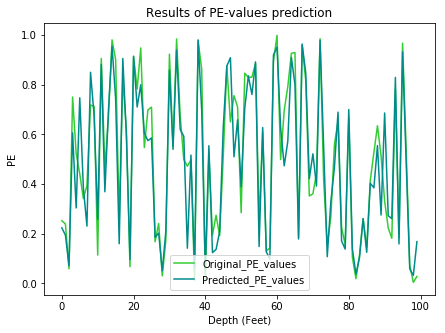

In [359]:
y_ = list(y_testp)
plt.figure(figsize=(7,5))
plt.plot(y_[0:100], color = 'limegreen', label = 'Original_PE_values')
plt.plot(predp[0:100], color = 'darkcyan', label = 'Predicted_PE_values')
plt.legend()
plt.title("Results of PE-values prediction")
plt.xlabel('Depth (Feet)')
plt.ylabel('PE')

In [316]:
# EMD QT
yp = eemd_pt_train['3'] # PE
eemd_pt_train_ = eemd_pt_train.drop(['3'],axis=1)
X_trainp, X_testp, y_trainp, y_testp = train_test_split(eemd_pt_train_, yp, test_size=0.25)
model = XGBRegressor(learning_rate = 0.1, max_depth = 6, n_estimators = 150)
model.fit(X_trainp,y_trainp)
predp = model.predict(X_testp)
print (mean_squared_error(y_testp,predp))
print (mean_absolute_error(y_testp,predp))        
print (r2_score(y_testp,predp))

0.1677903598845122
0.30733262764607394
0.8459960748849273


In [346]:
# EEMD QT
yp1 = eemd_pt_train['3'] # PE
eemd_pt_train_ = eemd_pt_train.drop(['3'],axis=1)
X_trainp1, X_testp1, y_trainp1, y_testp1 = train_test_split(eemd_pt_train_, yp1, test_size=0.25)
model = XGBRegressor(learning_rate = 0.1, max_depth = 5, n_estimators = 300)
model.fit(X_trainp1,y_trainp1)
predp1 = model.predict(X_testp1)
print (mean_squared_error(y_testp1,predp1))
print (mean_absolute_error(y_testp1,predp1))        
print (r2_score(y_testp1,predp1))

0.14693115006834398
0.3001209073611734
0.8591870331720571


Text(0, 0.5, 'PE')

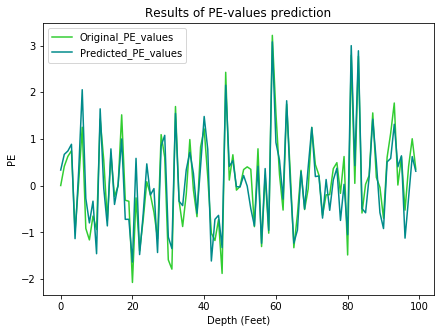

In [358]:
y_ = list(y_testp1)
plt.figure(figsize=(7,5))
plt.plot(y_[0:100], color = 'limegreen', label = 'Original_PE_values')
plt.plot(predp1[0:100], color = 'darkcyan', label = 'Predicted_PE_values')
plt.legend()
plt.title("Results of PE-values prediction")
plt.xlabel('Depth (Feet)')
plt.ylabel('PE')

In [96]:
predp.mean()

0.025198474877640785

In [100]:
y_testp.mean()

0.0238773220793684

In [79]:
# EMD SS
y1 = emd_ss_train['3'] # PE
emd_ss_train_ = emd_ss_train.drop(['3'],axis=1)
X_train1, X_test1, y_train1, y_test1 = train_test_split(emd_ss_train_, y1, test_size=0.25)
model = RandomForestRegressor(max_depth = 6, max_features = 'auto', n_estimators = 80)
model.fit(X_train1,y_train1)
pred1 = model.predict(X_test1)
print (mean_squared_error(y_test1,pred1))
print (mean_absolute_error(y_test1,pred1))        
print (r2_score(y_test1,pred1))

0.12630943771560565
0.2753313155863482
0.9018718946975486


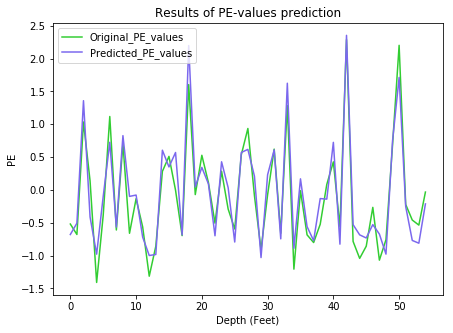

In [81]:
y_1 = list(y_test1)
fig = plt.figure(figsize=(7,5))
merged = merged.sort_values(by=['Depth'])
merged_=merged['Depth']
#merged_[0:55],
plt.plot(y_1[0:55], color = 'limegreen', label = 'Original_PE_values')
plt.plot(pred1[0:55], color = 'mediumslateblue', label = 'Predicted_PE_values')
plt.legend()
plt.title("Results of PE-values prediction")
plt.xlabel('Depth (Feet)')
plt.ylabel('PE')
fig.savefig('PE_pred.png')

In [70]:
from sklearn.model_selection import cross_val_score, KFold
k_fold = KFold(7, shuffle=True)
res1 = cross_val_score(RandomForestRegressor(max_depth = 6, max_features = 'auto' , n_estimators = 80), X_train, y_train, scoring='r2', cv=k_fold)
res2 = cross_val_score(RandomForestRegressor(max_depth = 6, max_features = 'auto' , n_estimators = 80), X_train, y_train, scoring='neg_mean_squared_error', cv=k_fold)
m_res1 = np.mean(res1)
m_res2 = np.mean(res2)
print(m_res1, '\n', m_res2)

0.8703362757194412 
 -0.1340838912938796


0.8660833592792266 
 -0.13535612289721902


In [92]:
y = emd_ss_train['3'] # PE
emd_ss_train_ = emd_ss_train.drop(['3'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(emd_ss_train_, y, test_size=0.25)
model = RandomForestRegressor(max_depth = 6, max_features = 'auto', n_estimators = 80)
model.fit(X_train,y_train)
pred = model.predict(X_test)
print (mean_squared_error(y_test,pred))
print (mean_absolute_error(y_test,pred))        
print (r2_score(y_test,pred))

0.2949965077511126
0.3803144914551743
0.6720493474081821


In [74]:
# EMD SS 2
y = emd_ss_train['3'] # PE
emd_ss_train_ = emd_ss_train.drop(['3'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(emd_ss_train_, y, test_size=0.25)
model = XGBRegressor(max_depth = 7, learning_rate = 0.1 , n_estimators = 150)
model.fit(X_train,y_train)
pred = model.predict(X_test)
print (mean_squared_error(y_test,pred))
print (mean_absolute_error(y_test,pred))        
print (r2_score(y_test,pred))

0.15480937748391377
0.26446195306511894
0.8400557041258601


In [79]:
from sklearn.model_selection import cross_val_score, KFold
k_fold = KFold(20, shuffle=True)
res1 = cross_val_score(XGBRegressor(max_depth = 7, learning_rate = 0.1 , n_estimators = 150), X_train, y_train, scoring='r2', cv=k_fold)
m_res = np.mean(res1)
m_res

0.825067542028474

In [82]:
from sklearn.model_selection import cross_val_score, KFold
k_fold = KFold(6, shuffle=True)
res1 = cross_val_score(XGBRegressor(max_depth = 7, learning_rate = 0.1 , n_estimators = 150), X_train, y_train, scoring='r2', cv=k_fold)
m_res = np.mean(res1)
m_res

0.8026354426014013

In [89]:
y = emd_mm_train['3'] # PE
emd_mm_train_ = emd_mm_train.drop(['3'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(emd_mm_train_, y, test_size=0.25)
model = XGBRegressor(max_depth = 7, learning_rate = 0.1 , n_estimators = 200)
model.fit(X_train,y_train)
pred = model.predict(X_test)
print (mean_squared_error(y_test,pred))
print (mean_absolute_error(y_test,pred))        
print (r2_score(y_test,pred))

0.0013817308164418693
0.02379300064694707
0.815300436173266


In [91]:
k_fold = KFold(10, shuffle=True)
res1 = cross_val_score(XGBRegressor(max_depth = 7, learning_rate = 0.1 , n_estimators = 200), X_train, y_train, scoring='r2', cv=k_fold)
m_res = np.mean(res1)
m_res

0.8132520131011439

In [85]:
y = emd_mm_train['3'] # PE
emd_mm_train_ = emd_mm_train.drop(['3'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(emd_mm_train_, y, test_size=0.25)
model = KNeighborsRegressor(algorithm = 'auto', n_neighbors = 2, weights = 'distance')
model.fit(X_train,y_train)
pred = model.predict(X_test)
print (mean_squared_error(y_test,pred))
print (mean_absolute_error(y_test,pred))        
print (r2_score(y_test,pred))

0.00026320300311817954
0.008907512142477479
0.9688482507356262


In [87]:
k_fold = KFold(10, shuffle=True)
res1 = cross_val_score(KNeighborsRegressor(algorithm = 'auto', n_neighbors = 2, weights = 'distance'), X_train, y_train, scoring='r2', cv=k_fold)
m_res = np.mean(res1)
m_res

0.9337219429643182

Text(0, 0.5, 'PE')

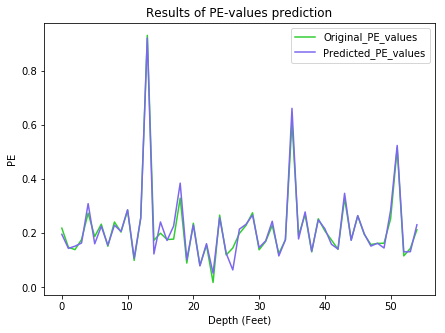

In [45]:
y_ = list(y_test)
plt.figure(figsize=(7,5))
plt.plot(y_[0:55], color = 'limegreen', label = 'Original_PE_values')
plt.plot(pred[0:55], color = 'mediumslateblue', label = 'Predicted_PE_values')
plt.legend()
plt.title("Results of PE-values prediction")
plt.xlabel('Depth (Feet)')
plt.ylabel('PE')

In [93]:
y = emd_mm_train['3'] # PE
emd_mm_train_ = emd_mm_train.drop(['3'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(emd_mm_train_, y, test_size=0.25)
model =  RandomForestRegressor(max_depth = 6, max_features = 'auto', n_estimators = 100)
model.fit(X_train,y_train)
pred = model.predict(X_test)
print (mean_squared_error(y_test,pred))
print (mean_absolute_error(y_test,pred))        
print (r2_score(y_test,pred))

0.002244877180720217
0.03347101181581952
0.6685412207631201


In [55]:
#X_test.set_index(['ind'])
merged = X_test.join(data['Depth'], how = 'right', lsuffix='_x')
merged = merged.dropna()

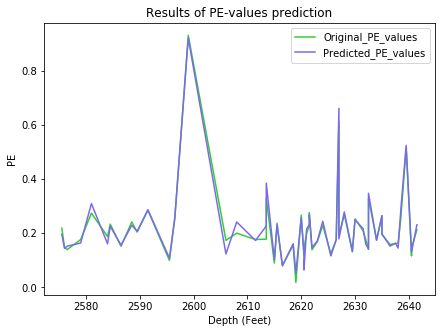

In [63]:
y_ = list(y_test)
fig = plt.figure(figsize=(7,5))
merged = merged.sort_values(by=['Depth'])
merged_=merged['Depth']
plt.plot(merged_[0:55], y_[0:55], color = 'limegreen', label = 'Original_PE_values')
plt.plot(merged_[0:55], pred[0:55], color = 'mediumslateblue', label = 'Predicted_PE_values')
plt.legend()
plt.title("Results of PE-values prediction")
plt.xlabel('Depth (Feet)')
plt.ylabel('PE')
fig.savefig('PE_pred.png')

In [38]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])

In [95]:
emd_ss_train

,Unnamed: 0,0,1,2,3,Faci1,Faci2,Faci3,Faci4,Faci5,Faci6,Faci7,Faci8,Faci9,PE
0,0,0.474458,0.024749,1.340598,-0.161540,0,0,1,0,0,0,0,0,0,0.976532
1,1,0.552003,0.001828,1.646668,-0.209751,0,0,1,0,0,0,0,0,0,0.418505
2,2,0.597447,-0.019477,1.853720,-0.180153,0,0,1,0,0,0,0,0,0,-0.139522
3,3,0.584878,-0.040723,1.943716,-0.065853,0,0,1,0,0,0,0,0,0,-0.251128
4,4,0.438954,-0.063275,1.973608,0.080980,0,0,1,0,0,0,0,0,0,-0.362733
5,5,0.298408,-0.087747,2.011106,0.193406,0,0,1,0,0,0,0,0,0,-0.139522
6,6,0.231295,-0.114367,2.104659,0.219752,0,0,1,0,0,0,0,0,0,-0.027917
7,7,0.270229,-0.142608,2.248373,0.170400,0,0,1,0,0,0,0,0,0,-0.251128
8,8,0.381159,-0.171965,2.388055,0.077414,0,0,1,0,0,0,0,0,0,-0.362733
9,9,0.359133,-0.203376,2.362177,-0.016697,0,0,1,0,0,0,0,0,0,-0.251128


In [159]:
# EMD SS
y_ = emd_ss_train['3'] # PE
emd_ss_train_ = emd_ss_train.drop(['3'],axis=1)
X_train_, X_test_, y_train_, y_test_ = train_test_split(emd_ss_train_, y_, test_size=0.25)
model = RandomForestRegressor(max_depth = 6, max_features = 'auto', n_estimators = 80)
model.fit(X_train_,y_train_)
pred_ = model.predict(X_test_)
print (mean_squared_error(y_test_,pred1))
print (mean_absolute_error(y_test_,pred_))        
print (r2_score(y_test1,pred1))

KeyError: '3'

In [80]:
fit_best_estimator(emd_ss_train,emd_ss_test,'EMD, StandardScale')
fit_best_estimator(emd_mm_train,emd_mm_test,'EMD, MinMaxScale')
fit_best_estimator(emd_qt_train,emd_qt_test,'EMD, QuantileTransform')
fit_best_estimator(emd_rs_train,emd_rs_test,'EMD, RobustScale')                            
fit_best_estimator(emd_pt_train,emd_pt_test,'EMD, PowerTransform')

Now its EMD, StandardScale noise and preprocessing types
RF

Params are:{'max_depth': 6, 'max_features': 'auto', 'n_estimators': 80}
MSE-0.29339044505734185
XGB

Params are:{'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 30}
MSE-0.2447263581852141
Ada

Params are:{'learning_rate': 0.1, 'n_estimators': 100}
MSE-0.3742114770045756
KNeighbors

Params are:{'algorithm': 'brute', 'n_neighbors': 5, 'weights': 'distance'}
MSE-0.2209660869228956
L1 regularized linear

Params are:{'alpha': 0.1}
MSE-0.6741083618532707
L2 regularized linear

Params are:{'alpha': 0.6500000000000001}
MSE-0.33775541511321183
For model RF MSE score is: 0.3079898346907763
For model RF MAE score is: 0.40180277693939287
For model RF R2 score is: 0.6987891693475076
For model XGB MSE score is: 0.24831657218984615
For model XGB MAE score is: 0.3465107342226089
For model XGB R2 score is: 0.7571489947089376
For model Ada MSE score is: 0.4265346862624377
For model Ada MAE score is: 0.5058176722355675
For model Ada R2 sc

In [153]:
fit_best_estimator(eemd_ss_train,eemd_ss_test,'EEMD, StandardScale')
fit_best_estimator(eemd_mm_train,eemd_mm_test,'EEMD, MinMaxScale')
fit_best_estimator(eemd_qt_train,eemd_qt_test,'EEMD, QuantileTransform')
fit_best_estimator(eemd_rs_train,eemd_rs_test,'EEMD, RobustScale')                            
fit_best_estimator(eemd_pt_train,eemd_pt_test,'EEMD, PowerTransform')

Now its EEMD, StandardScale noise and preprocessing types
RF

Params are:{'max_depth': 6, 'max_features': 'auto', 'n_estimators': 150}
MSE-0.3031479321714033
XGB

Params are:{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
MSE-0.2757722748683005
Ada

Params are:{'learning_rate': 0.5, 'n_estimators': 30}
MSE-0.38098988239734827
KNeighbors

Params are:{'algorithm': 'brute', 'n_neighbors': 8, 'weights': 'distance'}
MSE-0.26312079069044103
L1 regularized linear

Params are:{'alpha': 0.1}
MSE-0.5070615110261678
L2 regularized linear

Params are:{'alpha': 0.7000000000000002}
MSE-0.35392864515223615
For model RF MSE score is: 0.2892511171472948
For model RF MAE score is: 0.4032015843931212
For model RF R2 score is: 0.7092229092333195
For model XGB MSE score is: 0.24351288576526847
For model XGB MAE score is: 0.37002244735981593
For model XGB R2 score is: 0.7552024372961492
For model Ada MSE score is: 0.375901203800615
For model Ada MAE score is: 0.47253613663967203
For model Ada R2

In [229]:
fit_best_estimator(emd_ss_train,emd_ss_test,'EMD, StandardScale')
fit_best_estimator(emd_mm_train,emd_mm_test,'EMD, MinMaxScale')
fit_best_estimator(emd_qt_train,emd_qt_test,'EMD, QuantileTransform')
fit_best_estimator(emd_rs_train,emd_rs_test,'EMD, RobustScale')                            
fit_best_estimator(emd_pt_train,emd_pt_test,'EMD, PowerTransform')

Now its EMD, StandardScale noise and preprocessing types
RF

Params are:{'max_depth': 6, 'max_features': 'auto', 'n_estimators': 80}
MSE-0.0007603445068468723
XGB

Params are:{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300}
MSE-0.0006098035542247774
Ada

Params are:{'learning_rate': 0.1, 'n_estimators': 300}
MSE-0.009653233800269147
KNeighbors

Params are:{'algorithm': 'brute', 'n_neighbors': 2, 'weights': 'distance'}
MSE-0.0005134635163635041
L1 regularized linear

Params are:{'alpha': 0.1}
MSE-0.0898865909852167
L2 regularized linear

Params are:{'alpha': 0.9500000000000003}
MSE-0.0757762870769112
For model RF MSE score is: 0.0002511844068532308
For model RF MAE score is: 0.007200319989106102
For model RF R2 score is: 0.99974814822353
For model XGB MSE score is: 0.0003718061622385151
For model XGB MAE score is: 0.0033171863578548037
For model XGB R2 score is: 0.9996272059892755
For model Ada MSE score is: 0.009307746535356796
For model Ada MAE score is: 0.07593080860564942

In [ ]:
fit_best_estimator(eemd_ss_train,eemd_ss_test,'EEMD, StandardScale')
fit_best_estimator(eemd_mm_train,eemd_mm_test,'EEMD, MinMaxScale')
fit_best_estimator(eemd_qt_train,eemd_qt_test,'EEMD, QuantileTransform')
fit_best_estimator(eemd_rs_train,eemd_rs_test,'EEMD, RobustScale')
fit_best_estimator(eemd_pt_train,eemd_pt_test,'EEMD, PowerTransform')

In [198]:
fit_best_estimator(ceemd_ss_train,ceemd_ss_test,'CEEMD, StandardScale')
fit_best_estimator(ceemd_mm_train,ceemd_mm_test,'CEEMD, MinMaxScale')
fit_best_estimator(ceemd_qt_train,ceemd_qt_test,'CEEMD, QuantileTransform')
fit_best_estimator(ceemd_rs_train,ceemd_rs_test,'CEEMD, RobustScale')
fit_best_estimator(ceemd_pt_train,ceemd_pt_test,'CEEMD, PowerTransform')

Now its CEEMD, StandardScale noise and preprocessing types


AttributeError: 'str' object has no attribute 'items'

### <font color = "blue"> DATA VISUALIZATION (The logging diagram for well) </font>

In [4]:
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
good_data = pd.read_csv('data_good_ready.csv',encoding = 'utf-8')
facies_data = pd.read_csv('facies_data.csv',encoding = 'utf-8')

In [5]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as FF
plotly.tools.set_credentials_file(username='july_789', api_key='lgtWpXhF5JP9d8M3r2hS')

In [18]:
tb1 = FF.create_table(facies_data[5:16])#.head(10))
py.iplot(tb1,filename='facies_table')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~july_789/0 or inside your plot.ly account where it is named 'facies_table'


In [19]:
tb2 = FF.create_table(good_data[5:16])
py.iplot(tb2, filename='good_facies_table')

In [6]:
facies_colors = ['#F56F45', '#FA7E7E','#8C8456','#8F6A9E',
       '#226854','#9EDAAB', '#7C97FC', '#25C4EF', '#A7D909'] 

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
facies_color_map = {}
for i, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[i]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]

In [156]:
good_data.loc[:,'Label'] = good_data.apply(lambda row: label_facies(row, facies_labels), axis=1)
facies_data.loc[:,'Label'] = facies_data.apply(lambda row: label_facies(row, facies_labels), axis=1)

NameError: name 'good_data' is not defined

In [7]:
def make_facies_log_plot(logs, facies_colors):
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-g')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='black')
    ax[4].plot(logs.PE, logs.Depth, '-', color='r')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

### <font color = "blue"> Before data transform for well SHRIMPLIN</font>

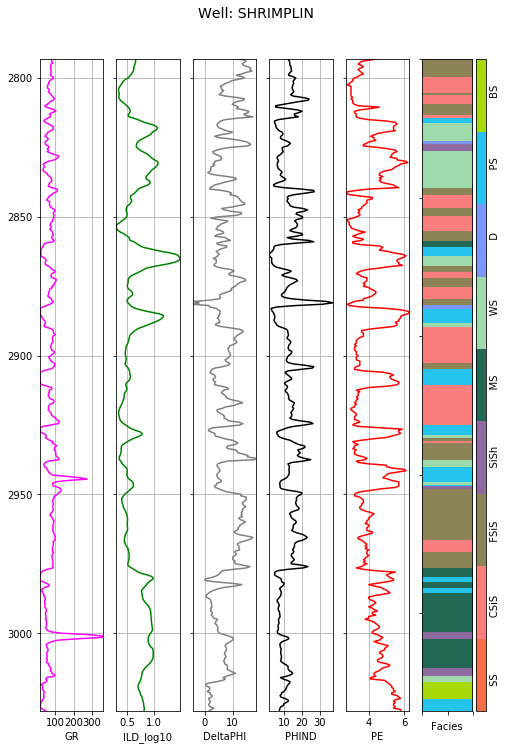

In [23]:
make_facies_log_plot(
    facies_data[facies_data['Well Name'] == 'SHRIMPLIN'],
    facies_colors)

### <font color = "blue"> After EMD data transfom for well SHRIMPLIN</font>

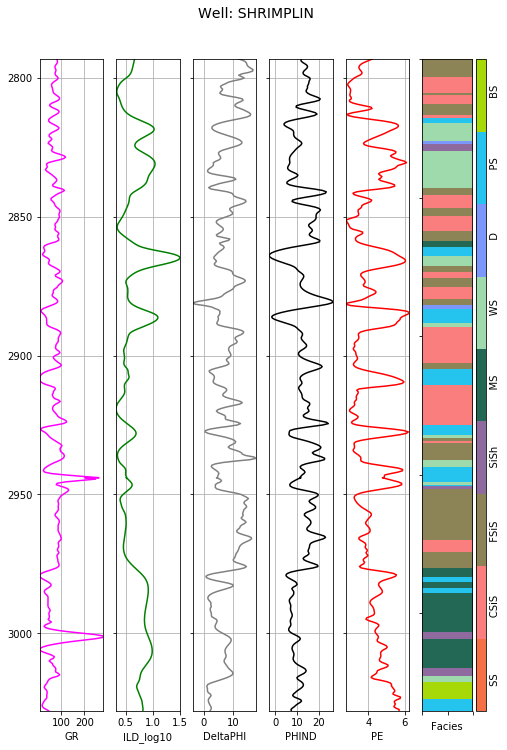

In [131]:
make_facies_log_plot(
    EMD_data[EMD_data['Well Name'] == 'SHRIMPLIN'],
    facies_colors)

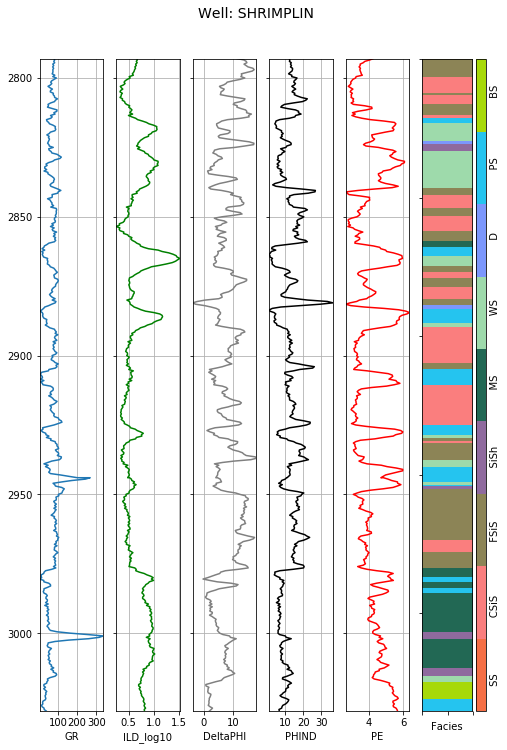

In [9]:
#EEMD_data = pd.read_csv('EEMD_data.csv', encoding = 'utf-8')
EEMD_data = pd.read_csv('EEMD_data01.csv', encoding = 'utf-8')
make_facies_log_plot(
    EEMD_data[EEMD_data['Well Name'] == 'SHRIMPLIN'],
    facies_colors)

In [120]:
eemd = EEMD (maximf = 5)
IMFs = eemd(np.array(facies_data[params[0]][facies_data['Well Name'] == wells[2]]))

Text(0, 0.5, 'GR (API)')

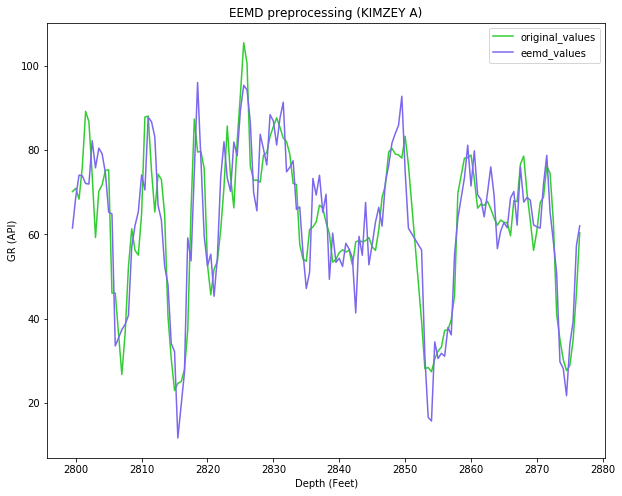

In [123]:
# KIMZEY A 
params = ['GR','ILD_log10',  'DeltaPHI','PHIND', 'PE']
facies_data = pd.read_csv('facies_data.csv',encoding = 'utf-8')
data1 = facies_data[[params[0],'Depth']][facies_data['Well Name'] == wells[2]]
data1 = data1.sort_values(by=['Depth'])
data1 = data1[50:200]
data2 = EEMD_data[[params[0],'Depth']][EEMD_data['Well Name'] == wells[2]]
data2 = data2.sort_values(by=['Depth'])
#data2.reset_index(inplace = True)
#data2 = data2.drop('index',axis=1)
IMFs_ = IMFs[0]
data2 = data2[50:200]
plt.figure(figsize=(10,8))
plt.plot(data1['Depth'],data1['GR'], color = 'limegreen', label = 'original_values')
plt.plot(data2['Depth'],data2['GR'] - IMFs_[50:200], color ='mediumslateblue', label='eemd_values')
plt.legend()

plt.title("EEMD preprocessing (KIMZEY A)")
plt.xlabel('Depth (Feet)')
plt.ylabel('GR (API)')

### <font color = "limegreen"> Feature engineering. Ранее данные были обработаны в 3 этапа, теперь нужно решить основную задачу мультиклассовой классификации. Для ее решения может быть полезным создание новых, дополнительных, признаков, которые помогут лучше классифицировать объекты -  фации. Создание дополнительных признаков  будет основано на знаниях из предметной области, точнее, на законе Вальтера (Э.Хэллем "Интерпретация фаций и стратиграфическая последовательность").
Из геологов XlX в. наиболее подробно обсуждал фациальные связи немецкий ученый Иогапнес Вальтер, известный как автор закона о соотношении фаций. Этот так называемый закон (или правило) Вальтера толковался по-разному, поэтому Миддлтои [324] попытался воспрепятствовать возможному смешению понятий, возвратясь к исходному определению, данному Вальтером, Миддлтон привел следующий отрывок из работы Вальтера, вышедшей в 1894 г. ([498], с, 979): 
«Различные отложения одной и той же фациальной области, как и совокупность пород разных фациальных областей, формируются рядом друг с другом в пространстве, хотя в разрезе мы видим их лежащими одни на других... Далеко идущее следствие такого утверждения состоит в том, что первично следуют друг за другом только те фации и фациальные области, которые в современных условиях наблюдаются рядом друг с другом».  </font>
https://ru.wikipedia.org/wiki/%D0%9B%D0%B8%D1%82%D0%BE%D0%BB%D0%BE%D0%B3%D0%B8%D1%8F - вот здесь смотри законы литологии о периодичности и корреляции фаций.
https://www.bygeo.ru/materialy/chetvertyi_kurs/uchenie-o-faciyah-lukashev-chtenie/2160-tektonicheskie-dvizheniya.html
Циклическое чередование фаций 

### <font color = "blue"> Feature correlation  </font>

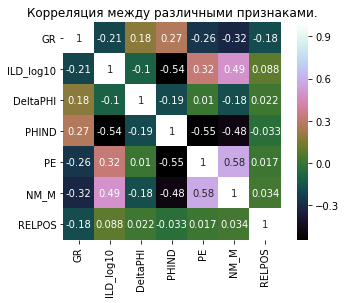

In [33]:
correlation = facies_data[features].fillna(facies_data.mean()).corr()
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')
plt.title('Корреляция между различными признаками.')
plt.show()

In [34]:
facies_data[features].fillna(facies_data.mean()).corr()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
GR,1.000000,-0.205855,0.178863,0.270730,-0.259732,-0.316284,-0.182051
ILD_log10,-0.205855,1.000000,-0.104827,-0.544401,0.324841,0.493570,0.088227
DeltaPHI,0.178863,-0.104827,1.000000,-0.189350,0.010051,-0.177500,0.022470
PHIND,0.270730,-0.544401,-0.189350,1.000000,-0.546253,-0.481014,-0.033335
PE,-0.259732,0.324841,0.010051,-0.546253,1.000000,0.580339,0.016694
NM_M,-0.316284,0.493570,-0.177500,-0.481014,0.580339,1.000000,0.034015
RELPOS,-0.182051,0.088227,0.022470,-0.033335,0.016694,0.034015,1.000000


🎓 Посмотрим также,какие признаки являются наиболее важными [feature importance](https://habr.com/post/342366/), а значит, с ними мы должны обязательно поработать,чтобы сделать итоговую модель как можно более качественной.

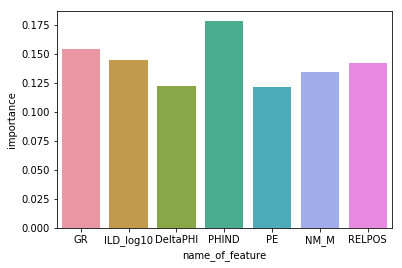

In [36]:
from sklearn.ensemble import RandomForestClassifier
facies = facies_data[['Facies','GR', 'ILD_log10', 'DeltaPHI', 'PHIND','PE','NM_M', 'RELPOS']].fillna(facies_data.mean())
model = RandomForestClassifier()
y,X = facies['Facies'],facies.drop('Facies',axis=1)
model.fit(X,y)
imp_f = pd.DataFrame({'name_of_feature':X.columns,'importance':model.feature_importances_})
sns.barplot(imp_f.name_of_feature,imp_f.importance)
plt.show()

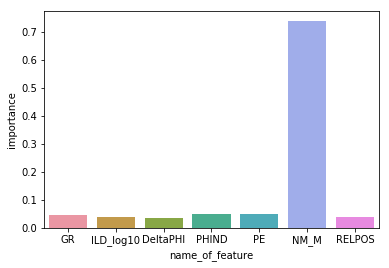

In [49]:
facies = facies_data[['Facies','GR', 'ILD_log10', 'DeltaPHI', 'PHIND','PE','NM_M', 'RELPOS']].fillna(facies_data.mean())
model = XGBClassifier(n_estimators = 150,max_depth = 7)
y,X = facies['Facies'],facies.drop('Facies',axis=1)
model.fit(X,y)
imp_f = pd.DataFrame({'name_of_feature':X.columns,'importance':model.feature_importances_})
sns.barplot(imp_f.name_of_feature,imp_f.importance)
plt.show()

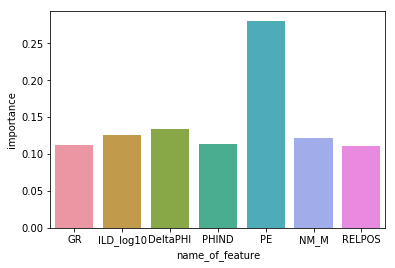

In [46]:
facies = good_data[['Facies','GR', 'ILD_log10', 'DeltaPHI', 'PHIND','PE','NM_M', 'RELPOS']]
model = XGBClassifier(n_estimators = 300,max_depth = 7)
y,X = facies['Facies'],facies.drop('Facies',axis=1)
model.fit(X,y)
imp_f = pd.DataFrame({'name_of_feature':X.columns,'importance':model.feature_importances_})
sns.barplot(imp_f.name_of_feature,imp_f.importance)
plt.show()

In [ ]:
# Feature engineering
#Наше предположение состоит в том, что фации не переходят из одного слоя глубины в другой. 
#Поэтому мы считаем признаки на соседних слоях коррелированными каким-то образом. 
#Чтобы возможно использовать этот факт, давайте выполним добавление признака с помощью:
#Агрегирование признаков на соседних глубинах.
#Вычисление пространственного градиента признака.

In [79]:
# Feature windows concatenation function
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]

    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))

    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row

    return X_aug

In [80]:
# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad

In [81]:
# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug, padded_rows

In [83]:
# Augment features
X = facies_data[features].fillna(facies_data.mean()).values
X_aug, padded_rows = augment_features(X, well, depth)

In [87]:
X_aug[1]

array([ 7.7450e+01,  6.6400e-01,  9.9000e+00,  1.1915e+01,  4.6000e+00,
        1.0000e+00,  1.0000e+00,  7.8260e+01,  6.6100e-01,  1.4200e+01,
        1.2565e+01,  4.1000e+00,  1.0000e+00,  9.7900e-01,  7.9050e+01,
        6.5800e-01,  1.4800e+01,  1.3050e+01,  3.6000e+00,  1.0000e+00,
        9.5700e-01,  1.5800e+00, -6.0000e-03,  1.2000e+00,  9.7000e-01,
       -1.0000e+00,  0.0000e+00, -4.4000e-02])

In [85]:
padded_rows

array([   0,  471,  698,  937, 1386, 1402, 1406, 1592, 1847, 2286, 2743,
       2787, 2893, 3202, 3282, 3514, 3745, 3784], dtype=int64)

In [88]:
X_aug.shape

(4149, 28)